# **Inner Evaluation: KFoldFastKmedoids**

## **Requirements**

In [6]:
import polars as pl
import pandas as pd
import numpy as np
import sys
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from  xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_style('whitegrid')

In [7]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\PyMachineLearning_Package_Private')
from PyMachineLearning.preprocessing import encoder, imputer, scaler, features_selector
from PyMachineLearning.evaluation import SimpleEvaluation


In [8]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\FastKmedoids_Package_Private')
from FastKmedoids.data import sort_predictors_for_GG

In [9]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\SupervisedClustering_Package_Private')
from SupervisedClustering.models import KFoldFastKmedoidsEstimator

In [10]:
sys.path.insert(0, r"C:\Users\fscielzo\Documents\Packages\BigEDA_Package_Private")
from BigEDA.descriptive import outliers_table

## **Data**

In [11]:
madrid_houses_df = pl.read_csv('Data/madrid_houses_NaNS.csv')
variables_to_remove = ['', 'id', 'district', 'neighborhood', 'sq_mt_allotment']
variables_to_keep = [x for x in madrid_houses_df.columns if x not in variables_to_remove]
madrid_houses_df = madrid_houses_df[variables_to_keep]
madrid_houses_df.head()

sq_mt_built,n_rooms,n_bathrooms,n_floors,floor,buy_price,is_renewal_needed,has_lift,is_exterior,energy_certificate,has_parking,house_type
f64,i64,i64,i64,i64,i64,bool,bool,bool,i64,bool,i64
64.0,2,1,1,3,85000,false,false,true,4,false,1
70.0,3,1,1,4,129900,true,true,true,0,false,1
94.0,2,2,1,1,144247,false,true,true,0,false,1
64.0,2,1,1,-1,109900,false,true,true,0,false,1
108.0,2,2,1,4,260000,false,true,true,0,true,1


In [12]:
quant_columns = ['sq_mt_built', 'n_rooms', 'n_bathrooms', 'n_floors', 'buy_price']
cat_columns = [x for x in madrid_houses_df.columns if x not in quant_columns]

response = 'buy_price'
quant_predictors = [x for x in quant_columns if x != response]
cat_predictors = [x for x in cat_columns if x != response]
predictors = quant_predictors + cat_predictors

In [13]:
cat_predictors_sorted, p1, p2, p3 = sort_predictors_for_GG(df=madrid_houses_df, quant_predictors=quant_predictors, cat_predictors=cat_predictors)

## **Response and Predictors**

In [14]:
Y = madrid_houses_df[response].to_pandas()
X = madrid_houses_df[predictors].to_pandas()
# The Null values of the Polars columns that are define as Object type by Pandas are treated as None and not as NaN (what we would like)
# The avoid this behavior the next step is necessary
X = X.fillna(value=np.nan)

## **Defining outer evaluation: train-test split**


In [15]:
# Defining the outer-evaluation: train-test split.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.90, random_state=123)
# We set a large train size since we are mainly interested in compare models not in estimating the feature performance (indeed, we could omit the test part and doing the inner eval. with the whole data)

## **Defining inner evaluation: K-Fold Cross Validation**

In [16]:
# Defining the inner-evaluation: K-fold cross validation
inner = KFold(n_splits=4, shuffle=True, random_state=111)

In [17]:
inner_score, best_params, inner_results = {}, {}, {}

## **Proportion of outliers**

In [18]:
Y_X_train = pd.concat((Y_train.reset_index(drop=True), X_train.reset_index(drop=True)), axis=1)
Y_X_train_pl = pl.DataFrame(Y_X_train)
mean_prop_outliers = np.round(outliers_table(df=Y_X_train_pl, auto=False, col_names=quant_columns)['prop_outliers'].mean(), 3)
mean_prop_outliers

0.09

## Example of usage

In [19]:
quant_pipeline = Pipeline([('imputer', imputer(apply=True, method='iterative_median'))])

cat_pipeline = Pipeline([('encoder', encoder(method='ordinal')),
                         ('imputer', imputer(apply=True, method='simple_most_frequent'))])

quant_cat_transformer = ColumnTransformer(transformers=[('quant', quant_pipeline, quant_predictors),
                                                        ('cat', cat_pipeline, cat_predictors_sorted)])

In [20]:
# Defining estimators to be used in each cluster
estimators_RF_XGB_2_clusters = {0: RandomForestRegressor(random_state=123),
                                1: XGBRegressor(random_state=123)}

In [21]:
X_train = quant_cat_transformer.fit_transform(X_train)
X_test = quant_cat_transformer.transform(X_test)
X_train = pd.DataFrame(X_train, columns=quant_predictors + cat_predictors_sorted)
X_test = pd.DataFrame(X_test, columns=quant_predictors + cat_predictors_sorted)

In [22]:
kfold_fast_kmedoids_regressor = KFoldFastKmedoidsEstimator(estimators=estimators_RF_XGB_2_clusters, 
                                                n_clusters=2, method='pam', init='heuristic', max_iter=100, 
                                                random_state=123,  frac_sample_size=0.01, 
                                                p1=p1, p2=p2, p3=p3, 
                                                d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                                                robust_maha_method='trimmed', alpha=0.05, 
                                                n_splits=10, shuffle=True, kfold_random_state=123,
                                                y_type='quantitative', verbose=False)

In [23]:
kfold_fast_kmedoids_regressor.fit(X=X_train, y=Y_train)
Y_test_hat = kfold_fast_kmedoids_regressor.predict(X_test)
mean_absolute_error(y_pred=Y_test_hat, y_true=Y_test)

Num.Folds: 10. Fold size: 1956.
Distance matrix size: 20 (0.01*1956) 
Num.Clusters: 2. Clusters proportions: [0.179862 0.820138]


187188.01804794648

## **Pipelines definition**

In [24]:
quant_pipeline = Pipeline([('imputer', imputer(apply=True)),
                           ('scaler', scaler())
                          ])

cat_pipeline = Pipeline([('encoder', encoder(method='ordinal')),
                         ('imputer', imputer(apply=True))
                        ])

quant_cat_preprocessing = ColumnTransformer(transformers=[('quant', quant_pipeline, quant_predictors),
                                                          ('cat', cat_pipeline, cat_predictors_sorted)]) 

In [25]:
meta_models = {'XGB': XGBRegressor(random_state=123),
               'RF': RandomForestRegressor(random_state=123)}

# We assume a maximum n_clusters of 5 along this notebook. To accept more clusters the following two lines should be modified.
clusters_RF = [0,2,4]
clusters_XGB = [1,3]

estimators_RF_XGB = {j: meta_models['RF'] for j in clusters_RF}
estimators_RF_XGB.update({j: meta_models['XGB'] for j in clusters_XGB}) 

clustering_estimator = KFoldFastKmedoidsEstimator(estimators=estimators_RF_XGB, 
                                                    n_clusters=2, method='pam', init='heuristic', max_iter=100, 
                                                    random_state=123,  frac_sample_size=0.015, 
                                                    p1=p1, p2=p2, p3=p3, 
                                                    d1='robust_mahalanobis', d2='jaccard', d3='matching', q=1,
                                                    robust_maha_method='trimmed', alpha=mean_prop_outliers, 
                                                    n_splits=5, shuffle=True, kfold_random_state=111,
                                                    y_type='quantitative', verbose=False)

pipeline_clustering_model = Pipeline([('preprocessing', quant_cat_preprocessing),
                                      ('features_selector', features_selector()),
                                      ('clustering_model', clustering_estimator)
                                     ]) 

## **Grids for HPO**

In [26]:
def preprocessing_param_grid(trial):

    # Fix Grid
    param_grid = {
        'preprocessing__quant__imputer__method': trial.suggest_categorical('preprocessing__quant__imputer__method', ['simple_mean', 'simple_median', 'iterative_mean', 'iterative_median']),
        'preprocessing__cat__imputer__method': trial.suggest_categorical('preprocessing__cat__imputer__method', ['simple_most_frequent']),
        'preprocessing__quant__scaler__apply': trial.suggest_categorical('preprocessing__quant__scaler__apply', [True, False]),
        'preprocessing__cat__encoder__method': trial.suggest_categorical('preprocessing__cat__encoder__method', ['ordinal']),  # with FastKmedoids only ordinal is suitable
        'features_selector__apply': trial.suggest_categorical('features_selector__apply', [False]) # with FastKmedoids we must not select predictors
        }

    # Conditioned Grid
    if param_grid['features_selector__apply'] == True:

        param_grid.update({'features_selector__method': trial.suggest_categorical('features_selector__method', ['Fpr_f_reg', 'Fdr_f_reg'])})
        
    if param_grid['preprocessing__quant__scaler__apply'] == True:
    
        param_grid.update({'preprocessing__quant__scaler__method': trial.suggest_categorical('preprocessing__quant__scaler__method', ['standard', 'min-max'])})

    return param_grid

In [27]:
def param_grid_clustering_model_robust_maha(trial):

    param_grid = {
        'clustering_model__n_clusters': trial.suggest_categorical('clustering_model__n_clusters', [2, 3]),
        'clustering_model__method': trial.suggest_categorical('clustering_model__method', ['pam', 'alternate']),
        'clustering_model__init': trial.suggest_categorical('clustering_model__init', ['random', 'heuristic', 'k-medoids++']),
        'clustering_model__frac_sample_size': trial.suggest_categorical('clustering_model__frac_sample_size', [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7]),
        'clustering_model__d1': trial.suggest_categorical('clustering_model__d1', ['robust_mahalanobis']),
        'clustering_model__d2': trial.suggest_categorical('clustering_model__d2', ['jaccard', 'sokal']),
        'clustering_model__n_splits': trial.suggest_int('clustering_model__n_splits', 3, 50)
    }

    if param_grid['clustering_model__d1'] == 'robust_mahalanobis':

        param_grid.update({
            'clustering_model__robust_maha_method': trial.suggest_categorical('clustering_model__robust_maha_method', ['trimmed', 'winsorized', 'MAD']),
            })

        if param_grid['clustering_model__robust_maha_method'] in ['trimmed', 'winsorized']:

                param_grid.update({
                        'clustering_model__alpha': trial.suggest_categorical('clustering_model__alpha', [0.05, mean_prop_outliers, 0.15, 0.2, 0.25, 0.30]),
                    })

    return param_grid

In [28]:
def param_grid_clustering_model_other_distances(trial):

    param_grid = {
        'clustering_model__n_clusters': trial.suggest_categorical('clustering_model__n_clusters', [2, 3]),
        'clustering_model__method': trial.suggest_categorical('clustering_model__method', ['pam', 'alternate']),
        'clustering_model__init': trial.suggest_categorical('clustering_model__init', ['heuristic', 'random', 'k-medoids++']),
        'clustering_model__frac_sample_size': trial.suggest_categorical('clustering_model__frac_sample_size', [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7]),
        # mahalanobis is not considered in d1 since sometimes leads to Singular Matrix error (with small data, when n_splits is large or/and frac_sample_size small)
        'clustering_model__d1': trial.suggest_categorical('clustering_model__d1', ['euclidean', 'minkowski', 'canberra']), 
        'clustering_model__d2': trial.suggest_categorical('clustering_model__d2', ['jaccard', 'sokal']),
        'clustering_model__n_splits': trial.suggest_int('clustering_model__n_splits', 3, 50)
    }

    return param_grid

In [29]:
def param_grid_RF_XGB(trial, n_clusters, param_grid):

    for j in range(0, n_clusters): # Create grids only for the effective clusters

        # Grids for RF
        if j in clusters_RF:

            param_grid.update({
                f'clustering_model__estimators__{j}__n_estimators': trial.suggest_int(f'clustering_model__estimators__{j}__n_estimators', 50, 120),
                f'clustering_model__estimators__{j}__max_depth': trial.suggest_categorical(f'clustering_model__estimators__{j}__max_depth', [None, 3, 5, 7, 10, 20, 30, 40, 50]),
                f'clustering_model__estimators__{j}__min_samples_split': trial.suggest_int(f'clustering_model__estimators__{j}__min_samples_split', 2, 25),
                f'clustering_model__estimators__{j}__min_samples_leaf': trial.suggest_int(f'clustering_model__estimators__{j}__min_samples_leaf', 2, 25)
            })

        # Grids for XGB
        if j in clusters_XGB:  

            param_grid.update({
                f'clustering_model__estimators__{j}__max_depth': trial.suggest_categorical(f'clustering_model__estimators__{j}__max_depth', [None, 3, 5, 7, 10, 20, 30, 40, 50]),
                f'clustering_model__estimators__{j}__lambda': trial.suggest_float(f'clustering_model__estimators__{j}__lambda', 0, 0.5, step=0.1, log=False),
                f'clustering_model__estimators__{j}__n_estimators': trial.suggest_categorical(f'clustering_model__estimators__{j}__n_estimators', [30, 50, 70, 100, 150, 180]),
                f'clustering_model__estimators__{j}__eta': trial.suggest_float(f'clustering_model__estimators__{j}__eta', 0, 0.3, step=0.02, log=False),
                f'clustering_model__estimators__{j}__alpha': trial.suggest_float(f'clustering_model__estimators__{j}__alpha', 0.2, 1, step=0.01, log=False)
            })

    return param_grid


In [30]:
def param_grid_RF_XGB_robust_maha(trial):

    param_grid = preprocessing_param_grid(trial)
    param_grid.update(param_grid_clustering_model_robust_maha(trial))

    n_clusters = param_grid['clustering_model__n_clusters']

    param_grid = param_grid_RF_XGB(trial, n_clusters, param_grid)

    return param_grid

In [31]:
def param_grid_RF_XGB_other_distances(trial):

    param_grid = preprocessing_param_grid(trial)
    param_grid.update(param_grid_clustering_model_other_distances(trial))

    n_clusters = param_grid['clustering_model__n_clusters']

    param_grid = param_grid_RF_XGB(trial, n_clusters, param_grid)

    return param_grid

## **HPO**

### **d1 = robust_maha**

In [30]:
simple_eval = SimpleEvaluation(estimator=pipeline_clustering_model,  
                                cv=inner, 
                                param_grid=param_grid_RF_XGB_robust_maha,
                                search_method='optuna',
                                scoring='neg_mean_absolute_error', 
                                direction='maximize', 
                                n_trials=100, 
                                random_state=123)

simple_eval.fit(X=X_train, y=Y_train)
# Time: 

[I 2024-05-04 19:09:34,646] A new study created in memory with name: no-name-00b08222-12b6-4d3e-b130-e796987718f4


Num.Folds: 13. Fold size: 1128.
Distance matrix size: 452 (0.4*1128) 
Num.Clusters: 2. Clusters proportions: [0.03809719 0.96190281]
Num.Folds: 13. Fold size: 1128.
Distance matrix size: 452 (0.4*1128) 
Num.Clusters: 2. Clusters proportions: [0.25241924 0.74758076]
Num.Folds: 13. Fold size: 1128.
Distance matrix size: 452 (0.4*1128) 
Num.Clusters: 2. Clusters proportions: [0.98521194 0.01478806]
Num.Folds: 13. Fold size: 1128.
Distance matrix size: 452 (0.4*1128) 
Num.Clusters: 2. Clusters proportions: [0.43716778 0.56283222]


[I 2024-05-04 19:10:48,377] Trial 0 finished with value: -192182.8570571678 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.4, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 13, 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 113, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators_

Num.Folds: 31. Fold size: 473.
Distance matrix size: 332 (0.7*473) 
Num.Clusters: 2. Clusters proportions: [0.59824167 0.40175833]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 332 (0.7*473) 
Num.Clusters: 2. Clusters proportions: [0.98221344 0.01778656]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 332 (0.7*473) 
Num.Clusters: 2. Clusters proportions: [0.39573395 0.60426605]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 332 (0.7*473) 
Num.Clusters: 2. Clusters proportions: [0.58388987 0.41611013]


[I 2024-05-04 19:12:26,958] Trial 1 finished with value: -191485.06475173237 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.7, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 31, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.2, 'clustering_model__estimators__0__n_estimators': 72, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 15, 'clustering_model__estimators__1__max_de

Num.Folds: 24. Fold size: 611.
Distance matrix size: 123 (0.2*611) 
Num.Clusters: 3. Clusters proportions: [0.2125673  0.27615348 0.51127922]
Num.Folds: 24. Fold size: 611.
Distance matrix size: 123 (0.2*611) 
Num.Clusters: 3. Clusters proportions: [0.7189587  0.04463677 0.23640453]
Num.Folds: 24. Fold size: 611.
Distance matrix size: 123 (0.2*611) 
Num.Clusters: 3. Clusters proportions: [0.0301213  0.69599291 0.27388578]
Num.Folds: 24. Fold size: 611.
Distance matrix size: 123 (0.2*611) 
Num.Clusters: 3. Clusters proportions: [0.0408205  0.75330517 0.20587434]


[I 2024-05-04 19:14:03,125] Trial 2 finished with value: -200199.2063981119 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.2, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 24, 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 90, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 12, 'clustering_model__estimators__0__min_samples_leaf': 15, 'clustering_model__estimators__1__max_depth': 40, 'clustering_model__estimators__1__l

Num.Folds: 28. Fold size: 524.
Distance matrix size: 315 (0.6*524) 
Num.Clusters: 3. Clusters proportions: [0.23369454 0.2709739  0.49533156]
Num.Folds: 28. Fold size: 524.
Distance matrix size: 315 (0.6*524) 
Num.Clusters: 3. Clusters proportions: [0.45986098 0.24867112 0.2914679 ]
Num.Folds: 28. Fold size: 524.
Distance matrix size: 315 (0.6*524) 
Num.Clusters: 3. Clusters proportions: [0.36936077 0.38128663 0.2493526 ]
Num.Folds: 28. Fold size: 524.
Distance matrix size: 315 (0.6*524) 
Num.Clusters: 3. Clusters proportions: [0.2824724  0.47260461 0.24492299]


[I 2024-05-04 19:15:59,676] Trial 3 finished with value: -186290.2655812777 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.6, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 28, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.05, 'clustering_model__estimators__0__n_estimators': 106, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 2, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_

Num.Folds: 47. Fold size: 312.
Distance matrix size: 63 (0.2*312) 
Num.Clusters: 3. Clusters proportions: [0.55714578 0.44285422]
Num.Folds: 47. Fold size: 312.
Distance matrix size: 63 (0.2*312) 
Num.Clusters: 3. Clusters proportions: [1.]
Num.Folds: 47. Fold size: 312.
Distance matrix size: 63 (0.2*312) 
Num.Clusters: 3. Clusters proportions: [0.35000681 0.23974376 0.41024942]
Num.Folds: 47. Fold size: 312.
Distance matrix size: 63 (0.2*312) 
Num.Clusters: 3. Clusters proportions: [1.]


[W 2024-05-04 19:17:31,451] Trial 4 failed with parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.2, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 47, 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.2, 'clustering_model__estimators__0__n_estimators': 78, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_m

Num.Folds: 15. Fold size: 978.
Distance matrix size: 343 (0.35*978) 
Num.Clusters: 3. Clusters proportions: [0.46745723 0.48442718 0.04811559]
Num.Folds: 15. Fold size: 978.
Distance matrix size: 343 (0.35*978) 
Num.Clusters: 3. Clusters proportions: [0.06058334 0.04886193 0.89055472]
Num.Folds: 15. Fold size: 978.
Distance matrix size: 343 (0.35*978) 
Num.Clusters: 3. Clusters proportions: [0.03598201 0.94166553 0.02235246]
Num.Folds: 15. Fold size: 978.
Distance matrix size: 343 (0.35*978) 
Num.Clusters: 3. Clusters proportions: [0.04565899 0.77654355 0.17779746]


[I 2024-05-04 19:18:50,332] Trial 5 finished with value: -184967.4161747315 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.35, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 15, 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 65, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 12, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 5, 'clustering_mo

Num.Folds: 14. Fold size: 1048.
Distance matrix size: 158 (0.15*1048) 
Num.Clusters: 2. Clusters proportions: [0.03284945 0.96715055]
Num.Folds: 14. Fold size: 1048.
Distance matrix size: 158 (0.15*1048) 
Num.Clusters: 2. Clusters proportions: [0.23769933 0.76230067]
Num.Folds: 14. Fold size: 1048.
Distance matrix size: 158 (0.15*1048) 
Num.Clusters: 2. Clusters proportions: [0.02657762 0.97342238]
Num.Folds: 14. Fold size: 1048.
Distance matrix size: 158 (0.15*1048) 
Num.Clusters: 2. Clusters proportions: [0.01887693 0.98112307]


[I 2024-05-04 19:19:37,335] Trial 6 finished with value: -220231.56638282648 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.15, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 14, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.3, 'clustering_model__estimators__0__n_estimators': 52, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__la

Num.Folds: 4. Fold size: 3668.
Distance matrix size: 1101 (0.3*3668) 
Num.Clusters: 3. Clusters proportions: [0.04239079 0.5476726  0.40993662]
Num.Folds: 4. Fold size: 3668.
Distance matrix size: 1101 (0.3*3668) 
Num.Clusters: 3. Clusters proportions: [0.42926264 0.52589614 0.04484122]
Num.Folds: 4. Fold size: 3668.
Distance matrix size: 1101 (0.3*3668) 
Num.Clusters: 3. Clusters proportions: [0.78451683 0.08961428 0.12586888]
Num.Folds: 4. Fold size: 3668.
Distance matrix size: 1101 (0.3*3668) 
Num.Clusters: 3. Clusters proportions: [0.00783699 0.92755895 0.06460406]


[I 2024-05-04 19:21:27,001] Trial 7 finished with value: -192963.31690579487 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.3, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 4, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 67, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimato

Num.Folds: 13. Fold size: 1128.
Distance matrix size: 564 (0.5*1128) 
Num.Clusters: 2. Clusters proportions: [0.95740476 0.04259524]
Num.Folds: 13. Fold size: 1128.
Distance matrix size: 564 (0.5*1128) 
Num.Clusters: 2. Clusters proportions: [0.96245059 0.03754941]
Num.Folds: 13. Fold size: 1128.
Distance matrix size: 564 (0.5*1128) 
Num.Clusters: 2. Clusters proportions: [0.02814502 0.97185498]
Num.Folds: 13. Fold size: 1128.
Distance matrix size: 564 (0.5*1128) 
Num.Clusters: 2. Clusters proportions: [0.94336922 0.05663078]


[I 2024-05-04 19:23:41,110] Trial 8 finished with value: -184096.78902281323 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 13, 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 63, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__est

Num.Folds: 34. Fold size: 431.
Distance matrix size: 216 (0.5*431) 
Num.Clusters: 2. Clusters proportions: [0.96926327 0.03073673]
Num.Folds: 34. Fold size: 431.
Distance matrix size: 216 (0.5*431) 
Num.Clusters: 2. Clusters proportions: [0.97410386 0.02589614]
Num.Folds: 34. Fold size: 431.
Distance matrix size: 216 (0.5*431) 
Num.Clusters: 2. Clusters proportions: [0.099632 0.900368]
Num.Folds: 34. Fold size: 431.
Distance matrix size: 216 (0.5*431) 
Num.Clusters: 2. Clusters proportions: [0.9834401 0.0165599]


[I 2024-05-04 19:26:29,248] Trial 9 finished with value: -210680.195975984 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 34, 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 57, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 22, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators

Num.Folds: 49. Fold size: 299.
Distance matrix size: 150 (0.5*299) 
Num.Clusters: 2. Clusters proportions: [0.9786683 0.0213317]
Num.Folds: 49. Fold size: 299.
Distance matrix size: 150 (0.5*299) 
Num.Clusters: 2. Clusters proportions: [0.96906092 0.03093908]
Num.Folds: 49. Fold size: 299.
Distance matrix size: 150 (0.5*299) 
Num.Clusters: 2. Clusters proportions: [0.96497206 0.03502794]
Num.Folds: 49. Fold size: 299.
Distance matrix size: 150 (0.5*299) 
Num.Clusters: 2. Clusters proportions: [0.03352869 0.96647131]


[I 2024-05-04 19:30:32,622] Trial 10 finished with value: -192201.26337872518 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 49, 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 99, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 16, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': 10, 'clustering_mode

Num.Folds: 40. Fold size: 366.
Distance matrix size: 92 (0.25*366) 
Num.Clusters: 2. Clusters proportions: [0.96047161 0.03952839]
Num.Folds: 40. Fold size: 366.
Distance matrix size: 92 (0.25*366) 
Num.Clusters: 2. Clusters proportions: [0.0422516 0.9577484]
Num.Folds: 40. Fold size: 366.
Distance matrix size: 92 (0.25*366) 
Num.Clusters: 2. Clusters proportions: [0.02650947 0.97349053]
Num.Folds: 40. Fold size: 366.
Distance matrix size: 92 (0.25*366) 
Num.Clusters: 2. Clusters proportions: [0.96224615 0.03775385]


[I 2024-05-04 19:33:50,021] Trial 11 finished with value: -186478.64716487864 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.25, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 40, 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 82, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 23, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'c

Num.Folds: 17. Fold size: 863.
Distance matrix size: 87 (0.1*863) 
Num.Clusters: 3. Clusters proportions: [0.9401622  0.02651128 0.03332652]
Num.Folds: 17. Fold size: 863.
Distance matrix size: 87 (0.1*863) 
Num.Clusters: 3. Clusters proportions: [0.05744855 0.81054927 0.13200218]
Num.Folds: 17. Fold size: 863.
Distance matrix size: 87 (0.1*863) 
Num.Clusters: 3. Clusters proportions: [0.43716778 0.0528145  0.51001772]
Num.Folds: 17. Fold size: 863.
Distance matrix size: 87 (0.1*863) 
Num.Clusters: 3. Clusters proportions: [0.7900368  0.04709009 0.16287311]


[I 2024-05-04 19:35:42,761] Trial 12 finished with value: -185361.73584544298 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.1, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 17, 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 67, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 21, 'clustering_model__estimators__1__max_depth': None, 'clusteri

Num.Folds: 4. Fold size: 3668.
Distance matrix size: 1284 (0.35*3668) 
Num.Clusters: 3. Clusters proportions: [0.27369999 0.71007974 0.01622027]
Num.Folds: 4. Fold size: 3668.
Distance matrix size: 1284 (0.35*3668) 
Num.Clusters: 3. Clusters proportions: [0.02603244 0.26638953 0.70757803]
Num.Folds: 4. Fold size: 3668.
Distance matrix size: 1284 (0.35*3668) 
Num.Clusters: 3. Clusters proportions: [0.00620144 0.08518468 0.90861387]
Num.Folds: 4. Fold size: 3668.
Distance matrix size: 1284 (0.35*3668) 
Num.Clusters: 3. Clusters proportions: [0.55690337 0.06814774 0.37494889]


[I 2024-05-04 19:36:55,942] Trial 13 finished with value: -212736.50587842378 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.35, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 4, 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 79, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 18, 'clustering_model__estimators__0__min_samples_leaf': 19, 'clustering_model__estimators__1__max_depth': 3, 'clustering

Num.Folds: 21. Fold size: 698.
Distance matrix size: 245 (0.35*698) 
Num.Clusters: 3. Clusters proportions: [0.06154161 0.13071628 0.80774211]
Num.Folds: 21. Fold size: 698.
Distance matrix size: 245 (0.35*698) 
Num.Clusters: 3. Clusters proportions: [0.46538095 0.05567671 0.47894235]
Num.Folds: 21. Fold size: 698.
Distance matrix size: 245 (0.35*698) 
Num.Clusters: 3. Clusters proportions: [9.67561674e-01 2.04443233e-04 3.22338831e-02]
Num.Folds: 21. Fold size: 698.
Distance matrix size: 245 (0.35*698) 
Num.Clusters: 3. Clusters proportions: [0.04177457 0.20819136 0.75003407]


[I 2024-05-04 19:38:24,977] Trial 14 finished with value: -186623.33225871949 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.35, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 21, 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 59, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 13, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_

Num.Folds: 9. Fold size: 1630.
Distance matrix size: 571 (0.35*1630) 
Num.Clusters: 2. Clusters proportions: [0.96803653 0.03196347]
Num.Folds: 9. Fold size: 1630.
Distance matrix size: 571 (0.35*1630) 
Num.Clusters: 2. Clusters proportions: [0.26236882 0.73763118]
Num.Folds: 9. Fold size: 1630.
Distance matrix size: 571 (0.35*1630) 
Num.Clusters: 2. Clusters proportions: [0.03966199 0.96033801]
Num.Folds: 9. Fold size: 1630.
Distance matrix size: 571 (0.35*1630) 
Num.Clusters: 2. Clusters proportions: [0.94991141 0.05008859]


[I 2024-05-04 19:39:17,916] Trial 15 finished with value: -310518.3317339742 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.35, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 9, 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 50, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 24, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estim

Num.Folds: 20. Fold size: 733.
Distance matrix size: 367 (0.5*733) 
Num.Clusters: 3. Clusters proportions: [0.80065426 0.00333947 0.19600627]
Num.Folds: 20. Fold size: 733.
Distance matrix size: 367 (0.5*733) 
Num.Clusters: 3. Clusters proportions: [0.75323702 0.02351097 0.22325201]
Num.Folds: 20. Fold size: 733.
Distance matrix size: 367 (0.5*733) 
Num.Clusters: 3. Clusters proportions: [0.12982145 0.03421017 0.83596838]
Num.Folds: 20. Fold size: 733.
Distance matrix size: 367 (0.5*733) 
Num.Clusters: 3. Clusters proportions: [0.65994276 0.11401118 0.22604607]


[I 2024-05-04 19:41:11,769] Trial 16 finished with value: -191301.78403532348 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 20, 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 74, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 18, 'clustering_model__estimators__0__min_samples_leaf': 19, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model_

Num.Folds: 10. Fold size: 1467.
Distance matrix size: 441 (0.3*1467) 
Num.Clusters: 2. Clusters proportions: [0.96381108 0.03618892]
Num.Folds: 10. Fold size: 1467.
Distance matrix size: 441 (0.3*1467) 
Num.Clusters: 2. Clusters proportions: [0.01063105 0.98936895]
Num.Folds: 10. Fold size: 1467.
Distance matrix size: 441 (0.3*1467) 
Num.Clusters: 2. Clusters proportions: [0.98023715 0.01976285]
Num.Folds: 10. Fold size: 1467.
Distance matrix size: 441 (0.3*1467) 
Num.Clusters: 2. Clusters proportions: [0.12178002 0.87821998]


[I 2024-05-04 19:42:53,598] Trial 17 finished with value: -184877.74677707415 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.3, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 10, 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 88, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estima

Num.Folds: 8. Fold size: 1834.
Distance matrix size: 551 (0.3*1834) 
Num.Clusters: 2. Clusters proportions: [0.79956382 0.20043618]
Num.Folds: 8. Fold size: 1834.
Distance matrix size: 551 (0.3*1834) 
Num.Clusters: 2. Clusters proportions: [0.34912089 0.65087911]
Num.Folds: 8. Fold size: 1834.
Distance matrix size: 551 (0.3*1834) 
Num.Clusters: 2. Clusters proportions: [0.26318659 0.73681341]
Num.Folds: 8. Fold size: 1834.
Distance matrix size: 551 (0.3*1834) 
Num.Clusters: 2. Clusters proportions: [0.98602971 0.01397029]


[I 2024-05-04 19:45:15,735] Trial 18 finished with value: -185137.29187488643 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.3, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 8, 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 93, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 2, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__

Num.Folds: 9. Fold size: 1630.
Distance matrix size: 489 (0.3*1630) 
Num.Clusters: 2. Clusters proportions: [0.07074218 0.92925782]
Num.Folds: 9. Fold size: 1630.
Distance matrix size: 489 (0.3*1630) 
Num.Clusters: 2. Clusters proportions: [0.5862069 0.4137931]
Num.Folds: 9. Fold size: 1630.
Distance matrix size: 489 (0.3*1630) 
Num.Clusters: 2. Clusters proportions: [0.61053564 0.38946436]
Num.Folds: 9. Fold size: 1630.
Distance matrix size: 489 (0.3*1630) 
Num.Clusters: 2. Clusters proportions: [0.44221071 0.55778929]


[I 2024-05-04 19:46:28,868] Trial 19 finished with value: -185757.061043827 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.3, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 9, 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 85, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 17, 'clustering_model__estimators__1__m

Num.Folds: 3. Fold size: 4891.
Distance matrix size: 734 (0.15*4891) 
Num.Clusters: 2. Clusters proportions: [0.30000682 0.69999318]
Num.Folds: 3. Fold size: 4891.
Distance matrix size: 734 (0.15*4891) 
Num.Clusters: 2. Clusters proportions: [0.54088865 0.45911135]
Num.Folds: 3. Fold size: 4891.
Distance matrix size: 734 (0.15*4891) 
Num.Clusters: 2. Clusters proportions: [0.79623824 0.20376176]
Num.Folds: 3. Fold size: 4891.
Distance matrix size: 734 (0.15*4891) 
Num.Clusters: 2. Clusters proportions: [0.64849393 0.35150607]


[I 2024-05-04 19:47:28,908] Trial 20 finished with value: -191452.35457931805 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.15, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 3, 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 99, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 25, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1_

Num.Folds: 23. Fold size: 637.
Distance matrix size: 446 (0.7*637) 
Num.Clusters: 2. Clusters proportions: [0.97307981 0.02692019]
Num.Folds: 23. Fold size: 638.
Distance matrix size: 447 (0.7*638) 
Num.Clusters: 2. Clusters proportions: [0.02528281 0.97471719]
Num.Folds: 23. Fold size: 638.
Distance matrix size: 447 (0.7*638) 
Num.Clusters: 2. Clusters proportions: [0.91215756 0.08784244]
Num.Folds: 23. Fold size: 638.
Distance matrix size: 447 (0.7*638) 
Num.Clusters: 2. Clusters proportions: [0.36513561 0.63486439]


[I 2024-05-04 19:49:06,966] Trial 21 finished with value: -189294.62083173546 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.7, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 23, 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 77, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__esti

Num.Folds: 15. Fold size: 978.
Distance matrix size: 245 (0.25*978) 
Num.Clusters: 3. Clusters proportions: [0.3522797  0.59865058 0.04906972]
Num.Folds: 15. Fold size: 978.
Distance matrix size: 245 (0.25*978) 
Num.Clusters: 3. Clusters proportions: [0.88701104 0.06310481 0.04988415]
Num.Folds: 15. Fold size: 978.
Distance matrix size: 245 (0.25*978) 
Num.Clusters: 3. Clusters proportions: [0.48085048 0.06092408 0.45822543]
Num.Folds: 15. Fold size: 978.
Distance matrix size: 245 (0.25*978) 
Num.Clusters: 3. Clusters proportions: [0.30891372 0.02923538 0.66185089]


[I 2024-05-04 19:50:43,311] Trial 22 finished with value: -188942.85910144768 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.25, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 15, 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 62, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 5, 'clustering_m

Num.Folds: 11. Fold size: 1333.
Distance matrix size: 134 (0.1*1333) 
Num.Clusters: 2. Clusters proportions: [0.98371158 0.01628842]
Num.Folds: 11. Fold size: 1334.
Distance matrix size: 134 (0.1*1334) 
Num.Clusters: 2. Clusters proportions: [0.6858389 0.3141611]
Num.Folds: 11. Fold size: 1334.
Distance matrix size: 134 (0.1*1334) 
Num.Clusters: 2. Clusters proportions: [0.96912907 0.03087093]
Num.Folds: 11. Fold size: 1334.
Distance matrix size: 134 (0.1*1334) 
Num.Clusters: 2. Clusters proportions: [0.97526237 0.02473763]


[I 2024-05-04 19:52:04,223] Trial 23 finished with value: -191292.82616443827 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.1, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 11, 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 68, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 30, 'clusterin

Num.Folds: 18. Fold size: 815.
Distance matrix size: 326 (0.4*815) 
Num.Clusters: 3. Clusters proportions: [0.52286513 0.04177741 0.43535746]
Num.Folds: 18. Fold size: 815.
Distance matrix size: 326 (0.4*815) 
Num.Clusters: 3. Clusters proportions: [0.56078779 0.04204716 0.39716505]
Num.Folds: 18. Fold size: 815.
Distance matrix size: 326 (0.4*815) 
Num.Clusters: 3. Clusters proportions: [0.1161919  0.05322339 0.83058471]
Num.Folds: 18. Fold size: 815.
Distance matrix size: 326 (0.4*815) 
Num.Clusters: 3. Clusters proportions: [0.75984735 0.04722639 0.19292626]


[I 2024-05-04 19:54:30,866] Trial 24 finished with value: -193739.12040483012 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.4, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 18, 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.3, 'clustering_model__estimators__0__n_estimators': 92, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 4, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimator

Num.Folds: 7. Fold size: 2096.
Distance matrix size: 420 (0.2*2096) 
Num.Clusters: 2. Clusters proportions: [0.09875281 0.90124719]
Num.Folds: 7. Fold size: 2096.
Distance matrix size: 420 (0.2*2096) 
Num.Clusters: 2. Clusters proportions: [0.9970015 0.0029985]
Num.Folds: 7. Fold size: 2096.
Distance matrix size: 420 (0.2*2096) 
Num.Clusters: 2. Clusters proportions: [0.03945754 0.96054246]
Num.Folds: 7. Fold size: 2096.
Distance matrix size: 420 (0.2*2096) 
Num.Clusters: 2. Clusters proportions: [0.02671392 0.97328608]


[I 2024-05-04 19:56:25,386] Trial 25 finished with value: -188064.99500159902 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.2, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 7, 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 62, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 40, 'clustering_mode

Num.Folds: 13. Fold size: 1128.
Distance matrix size: 677 (0.6*1128) 
Num.Clusters: 2. Clusters proportions: [0.97744156 0.02255844]
Num.Folds: 13. Fold size: 1128.
Distance matrix size: 677 (0.6*1128) 
Num.Clusters: 2. Clusters proportions: [0.02487393 0.97512607]
Num.Folds: 13. Fold size: 1128.
Distance matrix size: 677 (0.6*1128) 
Num.Clusters: 2. Clusters proportions: [0.1373177 0.8626823]
Num.Folds: 13. Fold size: 1128.
Distance matrix size: 677 (0.6*1128) 
Num.Clusters: 2. Clusters proportions: [0.95181954 0.04818046]


[I 2024-05-04 19:58:22,473] Trial 26 finished with value: -185563.21228839504 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.6, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 13, 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.2, 'clustering_model__estimators__0__n_estimators': 86, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 17, 'clustering_model__es

Num.Folds: 26. Fold size: 564.
Distance matrix size: 282 (0.5*564) 
Num.Clusters: 3. Clusters proportions: [0.74926736 0.04579841 0.20493423]
Num.Folds: 26. Fold size: 564.
Distance matrix size: 282 (0.5*564) 
Num.Clusters: 3. Clusters proportions: [0.76843396 0.05956113 0.17200491]
Num.Folds: 26. Fold size: 564.
Distance matrix size: 282 (0.5*564) 
Num.Clusters: 3. Clusters proportions: [0.05165599 0.76570806 0.18263595]
Num.Folds: 26. Fold size: 564.
Distance matrix size: 282 (0.5*564) 
Num.Clusters: 3. Clusters proportions: [0.77736132 0.03352869 0.18910999]


[I 2024-05-04 20:02:08,147] Trial 27 finished with value: -183121.09736862453 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 26, 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 71, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 17, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clusterin

Num.Folds: 38. Fold size: 386.
Distance matrix size: 193 (0.5*386) 
Num.Clusters: 2. Clusters proportions: [0.66884754 0.33115246]
Num.Folds: 38. Fold size: 386.
Distance matrix size: 193 (0.5*386) 
Num.Clusters: 2. Clusters proportions: [0.21289355 0.78710645]
Num.Folds: 38. Fold size: 386.
Distance matrix size: 193 (0.5*386) 
Num.Clusters: 2. Clusters proportions: [0.86656672 0.13343328]
Num.Folds: 38. Fold size: 386.
Distance matrix size: 193 (0.5*386) 
Num.Clusters: 2. Clusters proportions: [0.181273 0.818727]


[I 2024-05-04 20:05:49,777] Trial 28 finished with value: -185502.00480165778 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 38, 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.05, 'clustering_model__estimators__0__n_estimators': 72, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 18, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators_

Num.Folds: 28. Fold size: 524.
Distance matrix size: 262 (0.5*524) 
Num.Clusters: 3. Clusters proportions: [0.20561576 0.48401826 0.31036598]
Num.Folds: 28. Fold size: 524.
Distance matrix size: 262 (0.5*524) 
Num.Clusters: 3. Clusters proportions: [0.02071691 0.76352733 0.21575576]
Num.Folds: 28. Fold size: 524.
Distance matrix size: 262 (0.5*524) 
Num.Clusters: 3. Clusters proportions: [0.52078506 0.21432466 0.26489028]
Num.Folds: 28. Fold size: 524.
Distance matrix size: 262 (0.5*524) 
Num.Clusters: 3. Clusters proportions: [0.38448957 0.23592749 0.37958294]


[I 2024-05-04 20:10:01,402] Trial 29 finished with value: -179497.88321808394 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 28, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 55, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lamb

Num.Folds: 27. Fold size: 543.
Distance matrix size: 272 (0.5*543) 
Num.Clusters: 3. Clusters proportions: [0.5263409  0.25870647 0.21495263]
Num.Folds: 27. Fold size: 543.
Distance matrix size: 272 (0.5*543) 
Num.Clusters: 3. Clusters proportions: [0.44316478 0.31375221 0.243083  ]
Num.Folds: 27. Fold size: 543.
Distance matrix size: 272 (0.5*543) 
Num.Clusters: 3. Clusters proportions: [0.26407251 0.2674799  0.46844759]
Num.Folds: 27. Fold size: 543.
Distance matrix size: 272 (0.5*543) 
Num.Clusters: 3. Clusters proportions: [0.46401799 0.27599836 0.25998364]


[I 2024-05-04 20:14:29,788] Trial 30 finished with value: -179542.38442122366 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 27, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 117, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 13, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda

Num.Folds: 28. Fold size: 524.
Distance matrix size: 262 (0.5*524) 
Num.Clusters: 3. Clusters proportions: [0.20561576 0.48401826 0.31036598]
Num.Folds: 28. Fold size: 524.
Distance matrix size: 262 (0.5*524) 
Num.Clusters: 3. Clusters proportions: [0.02071691 0.76352733 0.21575576]
Num.Folds: 28. Fold size: 524.
Distance matrix size: 262 (0.5*524) 
Num.Clusters: 3. Clusters proportions: [0.52078506 0.21432466 0.26489028]
Num.Folds: 28. Fold size: 524.
Distance matrix size: 262 (0.5*524) 
Num.Clusters: 3. Clusters proportions: [0.38448957 0.23592749 0.37958294]


[I 2024-05-04 20:18:40,595] Trial 31 finished with value: -179769.10518763342 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 28, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 115, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda'

Num.Folds: 28. Fold size: 524.
Distance matrix size: 262 (0.5*524) 
Num.Clusters: 3. Clusters proportions: [0.20561576 0.48401826 0.31036598]
Num.Folds: 28. Fold size: 524.
Distance matrix size: 262 (0.5*524) 
Num.Clusters: 3. Clusters proportions: [0.02071691 0.76352733 0.21575576]
Num.Folds: 28. Fold size: 524.
Distance matrix size: 262 (0.5*524) 
Num.Clusters: 3. Clusters proportions: [0.52078506 0.21432466 0.26489028]
Num.Folds: 28. Fold size: 524.
Distance matrix size: 262 (0.5*524) 
Num.Clusters: 3. Clusters proportions: [0.38448957 0.23592749 0.37958294]


[I 2024-05-04 20:22:51,582] Trial 32 finished with value: -179769.10521318944 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 28, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 117, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda'

Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.45873373 0.31854426 0.22272201]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.46919722 0.27143247 0.25937031]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.25459997 0.4817364  0.26366362]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.23286084 0.31211667 0.45502249]


[I 2024-05-04 20:27:29,735] Trial 33 finished with value: -179508.31951835303 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 31, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 120, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda'

Num.Folds: 32. Fold size: 458.
Distance matrix size: 229 (0.5*458) 
Num.Clusters: 3. Clusters proportions: [0.4407415  0.33694541 0.22231309]
Num.Folds: 32. Fold size: 458.
Distance matrix size: 229 (0.5*458) 
Num.Clusters: 3. Clusters proportions: [0.24144746 0.48071419 0.27783835]
Num.Folds: 32. Fold size: 458.
Distance matrix size: 229 (0.5*458) 
Num.Clusters: 3. Clusters proportions: [0.35859343 0.37747036 0.26393621]
Num.Folds: 32. Fold size: 458.
Distance matrix size: 229 (0.5*458) 
Num.Clusters: 3. Clusters proportions: [0.24982963 0.44343737 0.306733  ]


[I 2024-05-04 20:31:51,192] Trial 34 finished with value: -179086.04791940647 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 32, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 119, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda'

Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.48006543 0.21699721 0.30293737]
Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.47519422 0.23585934 0.28894644]
Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.26311844 0.37821998 0.35866158]
Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.35368679 0.23347417 0.41283904]


[I 2024-05-04 20:37:09,300] Trial 35 finished with value: -181667.5234104441 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 33, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 110, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda':

Num.Folds: 38. Fold size: 386.
Distance matrix size: 155 (0.4*386) 
Num.Clusters: 3. Clusters proportions: [0.2512097  0.42854222 0.32024807]
Num.Folds: 38. Fold size: 386.
Distance matrix size: 155 (0.4*386) 
Num.Clusters: 3. Clusters proportions: [0.47110536 0.25650811 0.27238653]
Num.Folds: 38. Fold size: 386.
Distance matrix size: 155 (0.4*386) 
Num.Clusters: 3. Clusters proportions: [0.29174049 0.47124165 0.23701785]
Num.Folds: 38. Fold size: 386.
Distance matrix size: 155 (0.4*386) 
Num.Clusters: 3. Clusters proportions: [0.23217936 0.49509336 0.27272727]


[I 2024-05-04 20:42:01,809] Trial 36 finished with value: -180403.526662085 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.4, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 38, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 120, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 16, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda':

Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.45873373 0.31854426 0.22272201]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.46919722 0.27143247 0.25937031]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.25459997 0.4817364  0.26366362]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.23286084 0.31211667 0.45502249]


[I 2024-05-04 20:45:52,331] Trial 37 finished with value: -181491.91522387325 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 31, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 110, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 13, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda

Num.Folds: 31. Fold size: 473.
Distance matrix size: 332 (0.7*473) 
Num.Clusters: 3. Clusters proportions: [0.2454849  0.29537245 0.45914264]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 332 (0.7*473) 
Num.Clusters: 3. Clusters proportions: [0.23906229 0.5121303  0.24880741]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 332 (0.7*473) 
Num.Clusters: 3. Clusters proportions: [0.50572441 0.22291127 0.27136432]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 332 (0.7*473) 
Num.Clusters: 3. Clusters proportions: [0.47199128 0.30475671 0.22325201]


[I 2024-05-04 20:47:59,447] Trial 38 finished with value: -188000.98159507656 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.7, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 31, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 104, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 40, 'clustering_model__estimators__1__lambd

Num.Folds: 44. Fold size: 333.
Distance matrix size: 67 (0.2*333) 
Num.Clusters: 3. Clusters proportions: [0.33353779 0.46091461 0.2055476 ]
Num.Folds: 44. Fold size: 333.
Distance matrix size: 67 (0.2*333) 
Num.Clusters: 3. Clusters proportions: [0.50606515 0.27913316 0.21480169]
Num.Folds: 44. Fold size: 333.
Distance matrix size: 67 (0.2*333) 
Num.Clusters: 3. Clusters proportions: [0.2098269 0.5393894 0.2507837]
Num.Folds: 44. Fold size: 333.
Distance matrix size: 67 (0.2*333) 
Num.Clusters: 3. Clusters proportions: [0.78622053 0.02371542 0.19006406]


[I 2024-05-04 20:50:24,308] Trial 39 finished with value: -182772.862509151 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.2, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 44, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 120, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda

Num.Folds: 25. Fold size: 586.
Distance matrix size: 293 (0.5*586) 
Num.Clusters: 3. Clusters proportions: [0.23723847 0.28678525 0.47597628]
Num.Folds: 25. Fold size: 586.
Distance matrix size: 293 (0.5*586) 
Num.Clusters: 3. Clusters proportions: [0.47219572 0.24512744 0.28267684]
Num.Folds: 25. Fold size: 586.
Distance matrix size: 293 (0.5*586) 
Num.Clusters: 3. Clusters proportions: [0.2703421  0.29739676 0.43226114]
Num.Folds: 25. Fold size: 586.
Distance matrix size: 293 (0.5*586) 
Num.Clusters: 3. Clusters proportions: [0.36833856 0.25385035 0.37781109]


[I 2024-05-04 20:52:36,785] Trial 40 finished with value: -184645.15197107557 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 25, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 110, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lamb

Num.Folds: 35. Fold size: 419.
Distance matrix size: 252 (0.6*419) 
Num.Clusters: 3. Clusters proportions: [0.34771349 0.25516254 0.39712397]
Num.Folds: 35. Fold size: 419.
Distance matrix size: 252 (0.6*419) 
Num.Clusters: 3. Clusters proportions: [0.49277634 0.24274227 0.2644814 ]
Num.Folds: 35. Fold size: 419.
Distance matrix size: 252 (0.6*419) 
Num.Clusters: 3. Clusters proportions: [0.237086   0.27702058 0.48589342]
Num.Folds: 35. Fold size: 419.
Distance matrix size: 252 (0.6*419) 
Num.Clusters: 3. Clusters proportions: [0.45393212 0.24226523 0.30380264]


[I 2024-05-04 20:54:52,926] Trial 41 finished with value: -181406.68683429743 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.6, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 35, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 104, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 22, 'clustering_model__estimators__0__min_samples_leaf': 15, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambd

Num.Folds: 28. Fold size: 524.
Distance matrix size: 262 (0.5*524) 
Num.Clusters: 3. Clusters proportions: [0.20561576 0.48401826 0.31036598]
Num.Folds: 28. Fold size: 524.
Distance matrix size: 262 (0.5*524) 
Num.Clusters: 3. Clusters proportions: [0.02071691 0.76352733 0.21575576]
Num.Folds: 28. Fold size: 524.
Distance matrix size: 262 (0.5*524) 
Num.Clusters: 3. Clusters proportions: [0.52078506 0.21432466 0.26489028]
Num.Folds: 28. Fold size: 524.
Distance matrix size: 262 (0.5*524) 
Num.Clusters: 3. Clusters proportions: [0.38448957 0.23592749 0.37958294]


[I 2024-05-04 20:57:01,422] Trial 42 finished with value: -179767.50333950872 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 28, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 115, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda'

Num.Folds: 30. Fold size: 489.
Distance matrix size: 245 (0.5*489) 
Num.Clusters: 3. Clusters proportions: [0.50705377 0.2054113  0.28753493]
Num.Folds: 30. Fold size: 489.
Distance matrix size: 245 (0.5*489) 
Num.Clusters: 3. Clusters proportions: [0.2704784  0.41488347 0.31463814]
Num.Folds: 30. Fold size: 489.
Distance matrix size: 245 (0.5*489) 
Num.Clusters: 3. Clusters proportions: [0.46340466 0.23919858 0.29739676]
Num.Folds: 30. Fold size: 489.
Distance matrix size: 245 (0.5*489) 
Num.Clusters: 3. Clusters proportions: [0.23272455 0.41311163 0.35416383]


[I 2024-05-04 20:59:38,238] Trial 43 finished with value: -178589.66440058086 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 30, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 115, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 24, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda'

Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.45873373 0.31854426 0.22272201]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.46919722 0.27143247 0.25937031]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.25459997 0.4817364  0.26366362]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.23286084 0.31211667 0.45502249]


[I 2024-05-04 21:01:49,269] Trial 44 finished with value: -180735.61969381364 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 31, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 112, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 24, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda'

Num.Folds: 34. Fold size: 431.
Distance matrix size: 216 (0.5*431) 
Num.Clusters: 3. Clusters proportions: [0.2210182  0.30014312 0.47883868]
Num.Folds: 34. Fold size: 431.
Distance matrix size: 216 (0.5*431) 
Num.Clusters: 3. Clusters proportions: [0.50824588 0.23940303 0.2523511 ]
Num.Folds: 34. Fold size: 431.
Distance matrix size: 216 (0.5*431) 
Num.Clusters: 3. Clusters proportions: [0.25310072 0.44091591 0.30598337]
Num.Folds: 34. Fold size: 431.
Distance matrix size: 216 (0.5*431) 
Num.Clusters: 3. Clusters proportions: [0.22550089 0.49059561 0.2839035 ]


[I 2024-05-04 21:03:52,710] Trial 45 finished with value: -183948.10634424063 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 34, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 117, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 22, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lam

Num.Folds: 22. Fold size: 666.
Distance matrix size: 100 (0.15*666) 
Num.Clusters: 3. Clusters proportions: [0.80440264 0.16172562 0.03387174]
Num.Folds: 22. Fold size: 667.
Distance matrix size: 101 (0.15*667) 
Num.Clusters: 3. Clusters proportions: [0.02023988 0.74812594 0.23163418]
Num.Folds: 22. Fold size: 667.
Distance matrix size: 101 (0.15*667) 
Num.Clusters: 3. Clusters proportions: [0.75569034 0.02173913 0.22257053]
Num.Folds: 22. Fold size: 667.
Distance matrix size: 101 (0.15*667) 
Num.Clusters: 3. Clusters proportions: [0.48166826 0.3065967  0.21173504]


[I 2024-05-04 21:05:39,719] Trial 46 finished with value: -193445.17158019665 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.15, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 22, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 100, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 24, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambd

Num.Folds: 29. Fold size: 505.
Distance matrix size: 253 (0.5*505) 
Num.Clusters: 3. Clusters proportions: [0.20145846 0.49185579 0.30668575]
Num.Folds: 29. Fold size: 506.
Distance matrix size: 253 (0.5*506) 
Num.Clusters: 3. Clusters proportions: [0.26414066 0.50306665 0.23279269]
Num.Folds: 29. Fold size: 506.
Distance matrix size: 253 (0.5*506) 
Num.Clusters: 3. Clusters proportions: [0.32976693 0.10297124 0.56726182]
Num.Folds: 29. Fold size: 506.
Distance matrix size: 253 (0.5*506) 
Num.Clusters: 3. Clusters proportions: [0.43621371 0.23592749 0.3278588 ]


[I 2024-05-04 21:08:54,518] Trial 47 finished with value: -202400.60760541912 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 29, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.2, 'clustering_model__estimators__0__n_estimators': 113, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 13, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda'

Num.Folds: 36. Fold size: 407.
Distance matrix size: 102 (0.25*407) 
Num.Clusters: 3. Clusters proportions: [0.17794589 0.02610236 0.79595175]
Num.Folds: 36. Fold size: 407.
Distance matrix size: 102 (0.25*407) 
Num.Clusters: 3. Clusters proportions: [0.21514243 0.03618645 0.74867112]
Num.Folds: 36. Fold size: 407.
Distance matrix size: 102 (0.25*407) 
Num.Clusters: 3. Clusters proportions: [0.18175003 0.03754941 0.78070056]
Num.Folds: 36. Fold size: 407.
Distance matrix size: 102 (0.25*407) 
Num.Clusters: 3. Clusters proportions: [0.19585662 0.0272591  0.77688429]


[I 2024-05-04 21:11:28,666] Trial 48 finished with value: -187631.5078071628 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.25, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 36, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 107, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda

Num.Folds: 24. Fold size: 611.
Distance matrix size: 62 (0.1*611) 
Num.Clusters: 3. Clusters proportions: [0.34348804 0.61786956 0.0386424 ]
Num.Folds: 24. Fold size: 611.
Distance matrix size: 62 (0.1*611) 
Num.Clusters: 3. Clusters proportions: [0.03407387 0.76563991 0.20028622]
Num.Folds: 24. Fold size: 611.
Distance matrix size: 62 (0.1*611) 
Num.Clusters: 3. Clusters proportions: [0.02296579 0.79412566 0.18290855]
Num.Folds: 24. Fold size: 611.
Distance matrix size: 62 (0.1*611) 
Num.Clusters: 3. Clusters proportions: [0.74785335 0.03291536 0.21923129]


[I 2024-05-04 21:12:59,672] Trial 49 finished with value: -194299.1619217441 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.1, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 24, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.3, 'clustering_model__estimators__0__n_estimators': 120, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda':

Num.Folds: 44. Fold size: 333.
Distance matrix size: 167 (0.5*333) 
Num.Clusters: 3. Clusters proportions: [0.30075649 0.22122265 0.47802085]
Num.Folds: 44. Fold size: 333.
Distance matrix size: 167 (0.5*333) 
Num.Clusters: 3. Clusters proportions: [0.20669211 0.03495979 0.7583481 ]
Num.Folds: 44. Fold size: 333.
Distance matrix size: 167 (0.5*333) 
Num.Clusters: 3. Clusters proportions: [0.23272455 0.48003271 0.28724274]
Num.Folds: 44. Fold size: 333.
Distance matrix size: 167 (0.5*333) 
Num.Clusters: 3. Clusters proportions: [0.40316206 0.21514243 0.38169552]


[I 2024-05-04 21:16:18,755] Trial 50 finished with value: -184032.2075763 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 44, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.05, 'clustering_model__estimators__0__n_estimators': 116, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 24, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambd

Num.Folds: 30. Fold size: 489.
Distance matrix size: 245 (0.5*489) 
Num.Clusters: 3. Clusters proportions: [0.52838547 0.18701015 0.28460438]
Num.Folds: 30. Fold size: 489.
Distance matrix size: 245 (0.5*489) 
Num.Clusters: 3. Clusters proportions: [0.45597656 0.26993322 0.27409023]
Num.Folds: 30. Fold size: 489.
Distance matrix size: 245 (0.5*489) 
Num.Clusters: 3. Clusters proportions: [0.48412158 0.21480169 0.30107673]
Num.Folds: 30. Fold size: 489.
Distance matrix size: 245 (0.5*489) 
Num.Clusters: 3. Clusters proportions: [0.23081641 0.33644541 0.43273818]


[I 2024-05-04 21:20:39,992] Trial 51 finished with value: -192697.18804273373 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 30, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 53, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 22, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estimators__1__lambda'

Num.Folds: 27. Fold size: 543.
Distance matrix size: 272 (0.5*543) 
Num.Clusters: 3. Clusters proportions: [0.5263409  0.25870647 0.21495263]
Num.Folds: 27. Fold size: 543.
Distance matrix size: 272 (0.5*543) 
Num.Clusters: 3. Clusters proportions: [0.44316478 0.31375221 0.243083  ]
Num.Folds: 27. Fold size: 543.
Distance matrix size: 272 (0.5*543) 
Num.Clusters: 3. Clusters proportions: [0.26407251 0.2674799  0.46844759]
Num.Folds: 27. Fold size: 543.
Distance matrix size: 272 (0.5*543) 
Num.Clusters: 3. Clusters proportions: [0.46401799 0.27599836 0.25998364]


[I 2024-05-04 21:25:38,315] Trial 52 finished with value: -179158.54872803227 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 27, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 114, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda'

Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.48006543 0.21699721 0.30293737]
Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.47519422 0.23585934 0.28894644]
Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.26311844 0.37821998 0.35866158]
Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.35368679 0.23347417 0.41283904]


[I 2024-05-04 21:29:55,450] Trial 53 finished with value: -179437.720725879 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 33, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 107, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 24, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 

Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.48006543 0.21699721 0.30293737]
Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.47519422 0.23585934 0.28894644]
Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.26311844 0.37821998 0.35866158]
Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.35368679 0.23347417 0.41283904]


[I 2024-05-04 21:32:08,756] Trial 54 finished with value: -180603.1893447524 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 33, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 107, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 24, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda':

Num.Folds: 37. Fold size: 396.
Distance matrix size: 198 (0.5*396) 
Num.Clusters: 3. Clusters proportions: [0.23253595 0.1998228  0.56764125]
Num.Folds: 37. Fold size: 396.
Distance matrix size: 198 (0.5*396) 
Num.Clusters: 3. Clusters proportions: [0.17098269 0.80053155 0.02848576]
Num.Folds: 37. Fold size: 396.
Distance matrix size: 198 (0.5*396) 
Num.Clusters: 3. Clusters proportions: [0.22727273 0.74083413 0.03189314]
Num.Folds: 37. Fold size: 396.
Distance matrix size: 198 (0.5*396) 
Num.Clusters: 3. Clusters proportions: [0.24424152 0.5212621  0.23449639]


[I 2024-05-04 21:34:06,846] Trial 55 finished with value: -182016.0954002086 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 37, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 113, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda':

Num.Folds: 41. Fold size: 357.
Distance matrix size: 125 (0.35*357) 
Num.Clusters: 3. Clusters proportions: [0.48388196 0.23130921 0.28480883]
Num.Folds: 41. Fold size: 357.
Distance matrix size: 125 (0.35*357) 
Num.Clusters: 3. Clusters proportions: [0.26768434 0.231089   0.50122666]
Num.Folds: 41. Fold size: 357.
Distance matrix size: 125 (0.35*357) 
Num.Clusters: 3. Clusters proportions: [0.23068011 0.29392122 0.47539866]
Num.Folds: 41. Fold size: 357.
Distance matrix size: 125 (0.35*357) 
Num.Clusters: 3. Clusters proportions: [0.23374676 0.34060243 0.42565081]


[I 2024-05-04 21:36:28,560] Trial 56 finished with value: -185677.94255547744 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.35, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 41, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 102, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lam

Num.Folds: 32. Fold size: 458.
Distance matrix size: 321 (0.7*458) 
Num.Clusters: 3. Clusters proportions: [0.29210114 0.2268793  0.48101956]
Num.Folds: 32. Fold size: 458.
Distance matrix size: 321 (0.7*458) 
Num.Clusters: 3. Clusters proportions: [0.2507837  0.45359139 0.29562491]
Num.Folds: 32. Fold size: 458.
Distance matrix size: 321 (0.7*458) 
Num.Clusters: 3. Clusters proportions: [0.27654355 0.44425515 0.27920131]
Num.Folds: 32. Fold size: 458.
Distance matrix size: 321 (0.7*458) 
Num.Clusters: 3. Clusters proportions: [0.40466131 0.33719504 0.25814366]


[I 2024-05-04 21:38:33,805] Trial 57 finished with value: -189874.147719001 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.7, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 32, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 95, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0

Num.Folds: 25. Fold size: 586.
Distance matrix size: 235 (0.4*586) 
Num.Clusters: 3. Clusters proportions: [0.58542902 0.20404825 0.21052273]
Num.Folds: 25. Fold size: 586.
Distance matrix size: 235 (0.4*586) 
Num.Clusters: 3. Clusters proportions: [0.21262096 0.77088728 0.01649175]
Num.Folds: 25. Fold size: 586.
Distance matrix size: 235 (0.4*586) 
Num.Clusters: 3. Clusters proportions: [0.21970833 0.23401935 0.54627232]
Num.Folds: 25. Fold size: 586.
Distance matrix size: 235 (0.4*586) 
Num.Clusters: 3. Clusters proportions: [0.49597928 0.21616464 0.28785607]


[I 2024-05-04 21:40:23,869] Trial 58 finished with value: -188885.50121990638 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.4, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 25, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.2, 'clustering_model__estimators__0__n_estimators': 110, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 22, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 40, 'clustering_model__estimators__1__lambda

Num.Folds: 20. Fold size: 733.
Distance matrix size: 110 (0.15*733) 
Num.Clusters: 3. Clusters proportions: [0.52600014 0.19614257 0.27785729]
Num.Folds: 20. Fold size: 733.
Distance matrix size: 110 (0.15*733) 
Num.Clusters: 3. Clusters proportions: [0.49972741 0.24901186 0.25126073]
Num.Folds: 20. Fold size: 733.
Distance matrix size: 110 (0.15*733) 
Num.Clusters: 3. Clusters proportions: [0.34544092 0.37896961 0.27558948]
Num.Folds: 20. Fold size: 733.
Distance matrix size: 110 (0.15*733) 
Num.Clusters: 3. Clusters proportions: [0.35743492 0.25044296 0.39212212]


[I 2024-05-04 21:42:19,101] Trial 59 finished with value: -181611.97765117127 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.15, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 20, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 96, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 24, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__

Num.Folds: 26. Fold size: 564.
Distance matrix size: 113 (0.2*564) 
Num.Clusters: 3. Clusters proportions: [0.20568391 0.64213181 0.15218428]
Num.Folds: 26. Fold size: 564.
Distance matrix size: 113 (0.2*564) 
Num.Clusters: 3. Clusters proportions: [0.7899005  0.02848576 0.18161374]
Num.Folds: 26. Fold size: 564.
Distance matrix size: 113 (0.2*564) 
Num.Clusters: 3. Clusters proportions: [0.03461905 0.77477171 0.19060924]
Num.Folds: 26. Fold size: 564.
Distance matrix size: 113 (0.2*564) 
Num.Clusters: 3. Clusters proportions: [0.16048794 0.79766935 0.04184272]


[I 2024-05-04 21:43:56,106] Trial 60 finished with value: -182271.52158579841 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.2, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 26, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.3, 'clustering_model__estimators__0__n_estimators': 81, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 

Num.Folds: 40. Fold size: 366.
Distance matrix size: 183 (0.5*366) 
Num.Clusters: 3. Clusters proportions: [0.25277721 0.39044504 0.35677776]
Num.Folds: 40. Fold size: 366.
Distance matrix size: 183 (0.5*366) 
Num.Clusters: 3. Clusters proportions: [0.24710372 0.40602426 0.34687202]
Num.Folds: 40. Fold size: 366.
Distance matrix size: 183 (0.5*366) 
Num.Clusters: 3. Clusters proportions: [0.46940166 0.25466812 0.27593022]
Num.Folds: 40. Fold size: 366.
Distance matrix size: 183 (0.5*366) 
Num.Clusters: 3. Clusters proportions: [0.24942074 0.27361319 0.47696606]


[I 2024-05-04 21:49:00,934] Trial 61 finished with value: -202955.5793951663 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 40, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.05, 'clustering_model__estimators__0__n_estimators': 118, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda

Num.Folds: 29. Fold size: 505.
Distance matrix size: 253 (0.5*505) 
Num.Clusters: 3. Clusters proportions: [0.23682955 0.44755674 0.31561371]
Num.Folds: 29. Fold size: 506.
Distance matrix size: 253 (0.5*506) 
Num.Clusters: 3. Clusters proportions: [0.42687747 0.3080278  0.26509473]
Num.Folds: 29. Fold size: 506.
Distance matrix size: 253 (0.5*506) 
Num.Clusters: 3. Clusters proportions: [0.10085866 0.26584435 0.63329699]
Num.Folds: 29. Fold size: 506.
Distance matrix size: 253 (0.5*506) 
Num.Clusters: 3. Clusters proportions: [0.45877061 0.30209895 0.23913043]


[I 2024-05-04 21:53:23,884] Trial 62 finished with value: -181036.493838392 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 29, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 118, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 15, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda':

Num.Folds: 27. Fold size: 543.
Distance matrix size: 272 (0.5*543) 
Num.Clusters: 3. Clusters proportions: [0.5263409  0.25870647 0.21495263]
Num.Folds: 27. Fold size: 543.
Distance matrix size: 272 (0.5*543) 
Num.Clusters: 3. Clusters proportions: [0.44316478 0.31375221 0.243083  ]
Num.Folds: 27. Fold size: 543.
Distance matrix size: 272 (0.5*543) 
Num.Clusters: 3. Clusters proportions: [0.26407251 0.2674799  0.46844759]
Num.Folds: 27. Fold size: 543.
Distance matrix size: 272 (0.5*543) 
Num.Clusters: 3. Clusters proportions: [0.46401799 0.27599836 0.25998364]


[I 2024-05-04 21:55:46,100] Trial 63 finished with value: -181600.9055251647 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 27, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 114, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 24, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda':

Num.Folds: 34. Fold size: 431.
Distance matrix size: 216 (0.5*431) 
Num.Clusters: 3. Clusters proportions: [0.23158182 0.22551625 0.54290193]
Num.Folds: 34. Fold size: 431.
Distance matrix size: 216 (0.5*431) 
Num.Clusters: 3. Clusters proportions: [0.41904048 0.22093499 0.36002453]
Num.Folds: 34. Fold size: 431.
Distance matrix size: 216 (0.5*431) 
Num.Clusters: 3. Clusters proportions: [0.29644269 0.45052474 0.25303257]
Num.Folds: 34. Fold size: 431.
Distance matrix size: 216 (0.5*431) 
Num.Clusters: 3. Clusters proportions: [0.45147881 0.20928172 0.33923947]


[I 2024-05-04 21:57:54,982] Trial 64 finished with value: -180797.63796377147 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 34, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 112, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda

Num.Folds: 32. Fold size: 458.
Distance matrix size: 138 (0.3*458) 
Num.Clusters: 3. Clusters proportions: [0.30266476 0.19668779 0.50064745]
Num.Folds: 32. Fold size: 458.
Distance matrix size: 138 (0.3*458) 
Num.Clusters: 3. Clusters proportions: [0.23027123 0.26822952 0.50149925]
Num.Folds: 32. Fold size: 458.
Distance matrix size: 138 (0.3*458) 
Num.Clusters: 3. Clusters proportions: [0.23170233 0.51035846 0.25793921]
Num.Folds: 32. Fold size: 458.
Distance matrix size: 138 (0.3*458) 
Num.Clusters: 3. Clusters proportions: [0.28887829 0.24117487 0.46994684]


[I 2024-05-04 22:00:11,055] Trial 65 finished with value: -190536.73005321278 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.3, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 32, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 108, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambd

Num.Folds: 23. Fold size: 637.
Distance matrix size: 319 (0.5*637) 
Num.Clusters: 3. Clusters proportions: [0.24902883 0.33871737 0.4122538 ]
Num.Folds: 23. Fold size: 638.
Distance matrix size: 319 (0.5*638) 
Num.Clusters: 3. Clusters proportions: [0.47621644 0.29283086 0.23095271]
Num.Folds: 23. Fold size: 638.
Distance matrix size: 319 (0.5*638) 
Num.Clusters: 3. Clusters proportions: [0.28342647 0.24056154 0.47601199]
Num.Folds: 23. Fold size: 638.
Distance matrix size: 319 (0.5*638) 
Num.Clusters: 3. Clusters proportions: [0.45611285 0.26516287 0.27872427]


[I 2024-05-04 22:04:03,843] Trial 66 finished with value: -182978.55797171989 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 23, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 119, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda'

Num.Folds: 30. Fold size: 489.
Distance matrix size: 294 (0.6*489) 
Num.Clusters: 3. Clusters proportions: [0.5048729  0.28923874 0.20588837]
Num.Folds: 30. Fold size: 489.
Distance matrix size: 294 (0.6*489) 
Num.Clusters: 3. Clusters proportions: [0.45836173 0.26700286 0.27463541]
Num.Folds: 30. Fold size: 489.
Distance matrix size: 294 (0.6*489) 
Num.Clusters: 3. Clusters proportions: [0.45768025 0.24976148 0.29255827]
Num.Folds: 30. Fold size: 489.
Distance matrix size: 294 (0.6*489) 
Num.Clusters: 3. Clusters proportions: [0.3655445  0.24512744 0.38932806]


[I 2024-05-04 22:09:04,845] Trial 67 finished with value: -185539.2567333729 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.6, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 30, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 116, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 14, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estimators__1__lam

Num.Folds: 26. Fold size: 564.
Distance matrix size: 141 (0.25*564) 
Num.Clusters: 3. Clusters proportions: [0.14734546 0.27199618 0.58065835]
Num.Folds: 26. Fold size: 564.
Distance matrix size: 141 (0.25*564) 
Num.Clusters: 3. Clusters proportions: [0.74185634 0.02453319 0.23361047]
Num.Folds: 26. Fold size: 564.
Distance matrix size: 141 (0.25*564) 
Num.Clusters: 3. Clusters proportions: [0.02521467 0.17704784 0.79773749]
Num.Folds: 26. Fold size: 564.
Distance matrix size: 141 (0.25*564) 
Num.Clusters: 3. Clusters proportions: [0.20641952 0.24212894 0.55145155]


[I 2024-05-04 22:13:36,627] Trial 68 finished with value: -188712.46799726077 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.25, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 26, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 115, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 22, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambd

Num.Folds: 35. Fold size: 419.
Distance matrix size: 42 (0.1*419) 
Num.Clusters: 3. Clusters proportions: [0.21870102 0.27233695 0.50896204]
Num.Folds: 35. Fold size: 419.
Distance matrix size: 42 (0.1*419) 
Num.Clusters: 3. Clusters proportions: [0.03400572 0.80462042 0.16137386]
Num.Folds: 35. Fold size: 419.
Distance matrix size: 42 (0.1*419) 
Num.Folds: 35. Fold size: 419.
Distance matrix size: 42 (0.1*419) 
Num.Clusters: 3. Clusters proportions: [0.15442279 0.68161374 0.16396347]


[W 2024-05-04 22:17:21,309] Trial 69 failed with parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.1, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 35, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 104, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 24, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__e

Num.Folds: 29. Fold size: 505.
Distance matrix size: 51 (0.1*505) 
Num.Folds: 29. Fold size: 506.
Distance matrix size: 51 (0.1*506) 
Num.Clusters: 3. Clusters proportions: [0.19081368 0.21929944 0.58988687]
Num.Folds: 29. Fold size: 506.
Distance matrix size: 51 (0.1*506) 
Num.Clusters: 3. Clusters proportions: [0.7930353  0.18297669 0.02398801]
Num.Folds: 29. Fold size: 506.
Distance matrix size: 51 (0.1*506) 
Num.Clusters: 3. Clusters proportions: [0.04266049 0.16818863 0.78915088]


[W 2024-05-04 22:21:06,285] Trial 70 failed with parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.1, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 29, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 57, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 24, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__es

Num.Folds: 29. Fold size: 505.
Distance matrix size: 51 (0.1*505) 
Num.Folds: 29. Fold size: 506.
Distance matrix size: 51 (0.1*506) 
Num.Clusters: 3. Clusters proportions: [0.19081368 0.21929944 0.58988687]
Num.Folds: 29. Fold size: 506.
Distance matrix size: 51 (0.1*506) 
Num.Clusters: 3. Clusters proportions: [0.7930353  0.18297669 0.02398801]
Num.Folds: 29. Fold size: 506.
Distance matrix size: 51 (0.1*506) 
Num.Clusters: 3. Clusters proportions: [0.04266049 0.16818863 0.78915088]


[W 2024-05-04 22:25:13,175] Trial 71 failed with parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.1, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 29, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 104, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 24, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__e

Num.Folds: 36. Fold size: 407.
Distance matrix size: 41 (0.1*407) 
Num.Clusters: 3. Clusters proportions: [0.12887617 0.0426634  0.82846044]
Num.Folds: 36. Fold size: 407.
Distance matrix size: 41 (0.1*407) 
Num.Clusters: 3. Clusters proportions: [0.50306665 0.22236609 0.27456726]
Num.Folds: 36. Fold size: 407.
Distance matrix size: 41 (0.1*407) 
Num.Clusters: 3. Clusters proportions: [0.12409704 0.02650947 0.84939349]
Num.Folds: 36. Fold size: 407.
Distance matrix size: 41 (0.1*407) 
Num.Clusters: 3. Clusters proportions: [0.55847076 0.22093499 0.22059425]


[I 2024-05-04 22:30:34,280] Trial 72 finished with value: -182699.93597860704 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.1, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 36, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 104, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 24, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__l

Num.Folds: 27. Fold size: 543.
Distance matrix size: 272 (0.5*543) 
Num.Clusters: 3. Clusters proportions: [0.5263409  0.25870647 0.21495263]
Num.Folds: 27. Fold size: 543.
Distance matrix size: 272 (0.5*543) 
Num.Clusters: 3. Clusters proportions: [0.44316478 0.31375221 0.243083  ]
Num.Folds: 27. Fold size: 543.
Distance matrix size: 272 (0.5*543) 
Num.Clusters: 3. Clusters proportions: [0.26407251 0.2674799  0.46844759]
Num.Folds: 27. Fold size: 543.
Distance matrix size: 272 (0.5*543) 
Num.Clusters: 3. Clusters proportions: [0.46401799 0.27599836 0.25998364]


[I 2024-05-04 22:35:14,665] Trial 73 finished with value: -180299.1090935823 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 27, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 111, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda'

Num.Folds: 30. Fold size: 489.
Distance matrix size: 245 (0.5*489) 
Num.Clusters: 3. Clusters proportions: [0.51414162 0.27247325 0.21338513]
Num.Folds: 30. Fold size: 489.
Distance matrix size: 245 (0.5*489) 
Num.Clusters: 3. Clusters proportions: [0.23892599 0.48861933 0.27245468]
Num.Folds: 30. Fold size: 489.
Distance matrix size: 245 (0.5*489) 
Num.Clusters: 3. Clusters proportions: [0.43566853 0.24035709 0.32397438]
Num.Folds: 30. Fold size: 489.
Distance matrix size: 245 (0.5*489) 
Num.Clusters: 3. Clusters proportions: [0.24730816 0.42394712 0.32874472]


[I 2024-05-04 22:39:23,431] Trial 74 finished with value: -185116.6934120877 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 30, 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 108, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lamb

Num.Folds: 29. Fold size: 505.
Distance matrix size: 253 (0.5*505) 
Num.Clusters: 3. Clusters proportions: [0.23682955 0.44755674 0.31561371]
Num.Folds: 29. Fold size: 506.
Distance matrix size: 253 (0.5*506) 
Num.Clusters: 3. Clusters proportions: [0.42687747 0.3080278  0.26509473]
Num.Folds: 29. Fold size: 506.
Distance matrix size: 253 (0.5*506) 
Num.Clusters: 3. Clusters proportions: [0.10085866 0.26584435 0.63329699]
Num.Folds: 29. Fold size: 506.
Distance matrix size: 253 (0.5*506) 
Num.Clusters: 3. Clusters proportions: [0.45877061 0.30209895 0.23913043]


[I 2024-05-04 22:43:52,258] Trial 75 finished with value: -181460.2356853166 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 29, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 115, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda':

Num.Folds: 28. Fold size: 524.
Distance matrix size: 262 (0.5*524) 
Num.Clusters: 3. Clusters proportions: [0.20561576 0.48401826 0.31036598]
Num.Folds: 28. Fold size: 524.
Distance matrix size: 262 (0.5*524) 
Num.Clusters: 3. Clusters proportions: [0.02071691 0.76352733 0.21575576]
Num.Folds: 28. Fold size: 524.
Distance matrix size: 262 (0.5*524) 
Num.Clusters: 3. Clusters proportions: [0.52078506 0.21432466 0.26489028]
Num.Folds: 28. Fold size: 524.
Distance matrix size: 262 (0.5*524) 
Num.Clusters: 3. Clusters proportions: [0.38448957 0.23592749 0.37958294]


[I 2024-05-04 22:48:03,318] Trial 76 finished with value: -179767.50365615395 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 28, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 117, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 24, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda'

Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.48006543 0.21699721 0.30293737]
Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.47519422 0.23585934 0.28894644]
Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.26311844 0.37821998 0.35866158]
Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.35368679 0.23347417 0.41283904]


[I 2024-05-04 22:53:01,196] Trial 77 finished with value: -179689.0536375129 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 33, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 114, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda':

Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.48006543 0.21699721 0.30293737]
Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.47519422 0.23585934 0.28894644]
Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.26311844 0.37821998 0.35866158]
Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.35368679 0.23347417 0.41283904]


[I 2024-05-04 22:56:55,135] Trial 78 finished with value: -179683.1581100636 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 33, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 120, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda':

Num.Folds: 35. Fold size: 419.
Distance matrix size: 210 (0.5*419) 
Num.Clusters: 3. Clusters proportions: [0.25693451 0.32610918 0.41695631]
Num.Folds: 35. Fold size: 419.
Distance matrix size: 210 (0.5*419) 
Num.Clusters: 3. Clusters proportions: [0.26822952 0.2312253  0.50054518]
Num.Folds: 35. Fold size: 419.
Distance matrix size: 210 (0.5*419) 
Num.Clusters: 3. Clusters proportions: [0.48664304 0.26148289 0.25187406]
Num.Folds: 35. Fold size: 419.
Distance matrix size: 210 (0.5*419) 
Num.Clusters: 3. Clusters proportions: [0.42585525 0.32390623 0.25023852]


[I 2024-05-04 23:00:58,961] Trial 79 finished with value: -182999.98811564484 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 35, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 120, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 13, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lam

Num.Folds: 32. Fold size: 458.
Distance matrix size: 229 (0.5*458) 
Num.Clusters: 3. Clusters proportions: [0.54992162 0.30559531 0.14448306]
Num.Folds: 32. Fold size: 458.
Distance matrix size: 229 (0.5*458) 
Num.Clusters: 3. Clusters proportions: [0.42680932 0.54756713 0.02562355]
Num.Folds: 32. Fold size: 458.
Distance matrix size: 229 (0.5*458) 
Num.Clusters: 3. Clusters proportions: [0.4667439  0.32860842 0.20464768]
Num.Folds: 32. Fold size: 458.
Distance matrix size: 229 (0.5*458) 
Num.Clusters: 3. Clusters proportions: [0.41638272 0.34987052 0.23374676]


[I 2024-05-04 23:05:20,164] Trial 80 finished with value: -189045.50865543593 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 32, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.2, 'clustering_model__estimators__0__n_estimators': 118, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 22, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_d

Num.Folds: 30. Fold size: 489.
Distance matrix size: 172 (0.35*489) 
Num.Clusters: 3. Clusters proportions: [0.26265931 0.21318067 0.52416002]
Num.Folds: 30. Fold size: 489.
Distance matrix size: 172 (0.35*489) 
Num.Clusters: 3. Clusters proportions: [0.24383263 0.28465313 0.47151424]
Num.Folds: 30. Fold size: 489.
Distance matrix size: 172 (0.35*489) 
Num.Clusters: 3. Clusters proportions: [0.40847758 0.22577348 0.36574894]
Num.Folds: 30. Fold size: 489.
Distance matrix size: 172 (0.35*489) 
Num.Clusters: 3. Clusters proportions: [0.33406024 0.40466131 0.26127845]


[I 2024-05-04 23:09:43,482] Trial 81 finished with value: -181743.87021776213 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.35, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 30, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 120, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__la

Num.Folds: 35. Fold size: 419.
Distance matrix size: 294 (0.7*419) 
Num.Clusters: 3. Clusters proportions: [0.70871669 0.26054658 0.03073673]
Num.Folds: 35. Fold size: 419.
Distance matrix size: 294 (0.7*419) 
Num.Clusters: 3. Clusters proportions: [0.09465722 0.85443642 0.05090636]
Num.Folds: 35. Fold size: 419.
Distance matrix size: 294 (0.7*419) 
Num.Clusters: 3. Clusters proportions: [0.06126482 0.56071964 0.37801554]
Num.Folds: 35. Fold size: 419.
Distance matrix size: 294 (0.7*419) 
Num.Clusters: 3. Clusters proportions: [0.11551043 0.17963745 0.70485212]


[I 2024-05-04 23:12:54,592] Trial 82 finished with value: -328958.67409603583 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.7, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 35, 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 76, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 24, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__e

Num.Folds: 38. Fold size: 386.
Distance matrix size: 116 (0.3*386) 
Num.Clusters: 2. Clusters proportions: [0.87514482 0.12485518]
Num.Folds: 38. Fold size: 386.
Distance matrix size: 116 (0.3*386) 
Num.Clusters: 2. Clusters proportions: [0.84659943 0.15340057]
Num.Folds: 38. Fold size: 386.
Distance matrix size: 116 (0.3*386) 
Num.Clusters: 2. Clusters proportions: [0.14256508 0.85743492]
Num.Folds: 38. Fold size: 386.
Distance matrix size: 116 (0.3*386) 
Num.Clusters: 2. Clusters proportions: [0.85845714 0.14154286]


[I 2024-05-04 23:16:28,728] Trial 83 finished with value: -195504.3965843634 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.3, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 38, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.3, 'clustering_model__estimators__0__n_estimators': 56, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 18, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.

Num.Folds: 25. Fold size: 586.
Distance matrix size: 235 (0.4*586) 
Num.Clusters: 3. Clusters proportions: [0.47515845 0.23764738 0.28719417]
Num.Folds: 25. Fold size: 586.
Distance matrix size: 235 (0.4*586) 
Num.Clusters: 3. Clusters proportions: [0.22911272 0.46245059 0.30843669]
Num.Folds: 25. Fold size: 586.
Distance matrix size: 235 (0.4*586) 
Num.Clusters: 3. Clusters proportions: [0.30979965 0.21964018 0.47056017]
Num.Folds: 25. Fold size: 586.
Distance matrix size: 235 (0.4*586) 
Num.Clusters: 3. Clusters proportions: [0.28669756 0.48425787 0.22904457]


[I 2024-05-04 23:21:11,151] Trial 84 finished with value: -189465.08071756997 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.4, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 25, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 112, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 16, 'clustering_model__estimators__1__max_depth': 40, 'clustering_model__estimators__1__lambd

Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.48006543 0.21699721 0.30293737]
Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.47519422 0.23585934 0.28894644]
Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.26311844 0.37821998 0.35866158]
Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.35368679 0.23347417 0.41283904]


[I 2024-05-04 23:25:01,634] Trial 85 finished with value: -179689.05367743812 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 33, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 113, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda'

Num.Folds: 32. Fold size: 458.
Distance matrix size: 229 (0.5*458) 
Num.Clusters: 3. Clusters proportions: [0.4407415  0.33694541 0.22231309]
Num.Folds: 32. Fold size: 458.
Distance matrix size: 229 (0.5*458) 
Num.Clusters: 3. Clusters proportions: [0.24144746 0.48071419 0.27783835]
Num.Folds: 32. Fold size: 458.
Distance matrix size: 229 (0.5*458) 
Num.Clusters: 3. Clusters proportions: [0.35859343 0.37747036 0.26393621]
Num.Folds: 32. Fold size: 458.
Distance matrix size: 229 (0.5*458) 
Num.Clusters: 3. Clusters proportions: [0.24982963 0.44343737 0.306733  ]


[I 2024-05-04 23:27:04,851] Trial 86 finished with value: -180614.11646473862 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 32, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 116, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 24, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda'

Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.48006543 0.21699721 0.30293737]
Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.47519422 0.23585934 0.28894644]
Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.26311844 0.37821998 0.35866158]
Num.Folds: 33. Fold size: 444.
Distance matrix size: 222 (0.5*444) 
Num.Clusters: 3. Clusters proportions: [0.35368679 0.23347417 0.41283904]


[I 2024-05-04 23:29:33,492] Trial 87 finished with value: -179600.08548651097 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 33, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 109, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda'

Num.Folds: 29. Fold size: 505.
Distance matrix size: 253 (0.5*505) 
Num.Clusters: 3. Clusters proportions: [0.24603012 0.30825325 0.44571662]
Num.Folds: 29. Fold size: 506.
Distance matrix size: 253 (0.5*506) 
Num.Clusters: 3. Clusters proportions: [0.41767752 0.32070328 0.26161919]
Num.Folds: 29. Fold size: 506.
Distance matrix size: 253 (0.5*506) 
Num.Clusters: 3. Clusters proportions: [0.25398664 0.23688156 0.5091318 ]
Num.Folds: 29. Fold size: 506.
Distance matrix size: 253 (0.5*506) 
Num.Clusters: 3. Clusters proportions: [0.45856617 0.29896415 0.24246967]


[I 2024-05-04 23:31:34,169] Trial 88 finished with value: -189002.82834407198 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 29, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.05, 'clustering_model__estimators__0__n_estimators': 109, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 22, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda'

Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.24125946 0.42090915 0.33783139]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.27170506 0.25132888 0.47696606]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.25889328 0.29085457 0.45025215]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.2356549  0.30564263 0.45870247]


[I 2024-05-04 23:33:37,432] Trial 89 finished with value: -183422.7197427815 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 31, 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 105, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 21, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__l

Num.Folds: 27. Fold size: 543.
Distance matrix size: 109 (0.2*543) 
Num.Clusters: 3. Clusters proportions: [0.22231309 0.7516527  0.02603421]
Num.Folds: 27. Fold size: 543.
Distance matrix size: 109 (0.2*543) 
Num.Clusters: 3. Clusters proportions: [0.46210985 0.21889055 0.31899959]
Num.Folds: 27. Fold size: 543.
Distance matrix size: 109 (0.2*543) 
Num.Clusters: 3. Clusters proportions: [0.29085457 0.46776612 0.24137931]
Num.Folds: 27. Fold size: 543.
Distance matrix size: 109 (0.2*543) 
Num.Clusters: 3. Clusters proportions: [0.54027532 0.25473627 0.20498841]


[I 2024-05-04 23:35:24,331] Trial 90 finished with value: -181019.22139434548 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.2, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 27, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 118, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__la

Num.Folds: 24. Fold size: 611.
Distance matrix size: 92 (0.15*611) 
Num.Clusters: 3. Clusters proportions: [0.44448988 0.31527295 0.24023717]
Num.Folds: 24. Fold size: 611.
Distance matrix size: 92 (0.15*611) 
Num.Clusters: 3. Clusters proportions: [0.23892599 0.40302576 0.35804825]
Num.Folds: 24. Fold size: 611.
Distance matrix size: 92 (0.15*611) 
Num.Clusters: 3. Clusters proportions: [0.25371405 0.43703148 0.30925446]
Num.Folds: 24. Fold size: 611.
Distance matrix size: 92 (0.15*611) 
Num.Clusters: 3. Clusters proportions: [0.02303394 0.72672755 0.25023852]


[I 2024-05-04 23:37:30,604] Trial 91 finished with value: -196286.96421347745 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.15, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 24, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 64, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_d

Num.Folds: 34. Fold size: 431.
Distance matrix size: 216 (0.5*431) 
Num.Clusters: 3. Clusters proportions: [0.14155251 0.33483269 0.5236148 ]
Num.Folds: 34. Fold size: 431.
Distance matrix size: 216 (0.5*431) 
Num.Clusters: 3. Clusters proportions: [0.93696334 0.00449775 0.05853891]
Num.Folds: 34. Fold size: 431.
Distance matrix size: 216 (0.5*431) 
Num.Clusters: 3. Clusters proportions: [0.71943574 0.20832765 0.07223661]
Num.Folds: 34. Fold size: 431.
Distance matrix size: 216 (0.5*431) 
Num.Clusters: 3. Clusters proportions: [0.32342919 0.4606106  0.2159602 ]


[I 2024-05-04 23:39:37,563] Trial 92 finished with value: -208135.62197399762 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 34, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 89, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 24, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__la

Num.Folds: 36. Fold size: 407.
Distance matrix size: 245 (0.6*407) 
Num.Clusters: 2. Clusters proportions: [0.79165815 0.20834185]
Num.Folds: 36. Fold size: 407.
Distance matrix size: 245 (0.6*407) 
Num.Clusters: 2. Clusters proportions: [0.24226523 0.75773477]
Num.Folds: 36. Fold size: 407.
Distance matrix size: 245 (0.6*407) 
Num.Clusters: 2. Clusters proportions: [0.73620008 0.26379992]
Num.Folds: 36. Fold size: 407.
Distance matrix size: 245 (0.6*407) 
Num.Clusters: 2. Clusters proportions: [0.76509473 0.23490527]


[I 2024-05-04 23:41:43,021] Trial 93 finished with value: -193362.6844065972 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.6, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 36, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 114, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 22, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__la

Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.20936414 0.2782662  0.51236966]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.46994684 0.2539185  0.27613466]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.25071555 0.49379856 0.25548589]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.21998092 0.30775521 0.47226387]


[I 2024-05-04 23:43:20,925] Trial 94 finished with value: -178734.59519290435 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 31, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 111, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 3, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda

Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.20936414 0.2782662  0.51236966]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.46994684 0.2539185  0.27613466]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.25071555 0.49379856 0.25548589]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.21998092 0.30775521 0.47226387]


[I 2024-05-04 23:45:04,759] Trial 95 finished with value: -178772.292356197 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 31, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 102, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 17, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda'

Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.20936414 0.2782662  0.51236966]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.46994684 0.2539185  0.27613466]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.25071555 0.49379856 0.25548589]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.21998092 0.30775521 0.47226387]


[I 2024-05-04 23:46:52,325] Trial 96 finished with value: -178677.38312406585 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 31, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 103, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 16, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambd

Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.20936414 0.2782662  0.51236966]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.46994684 0.2539185  0.27613466]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.25071555 0.49379856 0.25548589]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.21998092 0.30775521 0.47226387]


[I 2024-05-04 23:48:36,370] Trial 97 finished with value: -178855.89415864486 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 31, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 98, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 16, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda

Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.20936414 0.2782662  0.51236966]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.46994684 0.2539185  0.27613466]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.25071555 0.49379856 0.25548589]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.21998092 0.30775521 0.47226387]


[I 2024-05-04 23:50:16,585] Trial 98 finished with value: -179154.75661671802 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 31, 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 102, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 16, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambd

Num.Folds: 29. Fold size: 505.
Distance matrix size: 127 (0.25*505) 
Num.Clusters: 3. Clusters proportions: [0.13405575 0.83370817 0.03223608]
Num.Folds: 29. Fold size: 506.
Distance matrix size: 127 (0.25*506) 
Num.Clusters: 3. Clusters proportions: [0.04586343 0.20566989 0.74846668]
Num.Folds: 29. Fold size: 506.
Distance matrix size: 127 (0.25*506) 
Num.Clusters: 3. Clusters proportions: [0.78996865 0.03789015 0.1721412 ]
Num.Folds: 29. Fold size: 506.
Distance matrix size: 127 (0.25*506) 
Num.Clusters: 3. Clusters proportions: [0.7916042  0.03257462 0.17582118]


[I 2024-05-04 23:51:56,071] Trial 99 finished with value: -183689.93549718818 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.25, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 29, 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 101, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimato

In [31]:
clustering_method = 'KFoldFastKmedoids-RobustMaha'
inner_score[clustering_method] = simple_eval.inner_score
best_params[clustering_method] = simple_eval.inner_best_params
inner_results[clustering_method] = simple_eval.inner_results

### **d1 != robust maha**

In [34]:
simple_eval = SimpleEvaluation(estimator=pipeline_clustering_model,  
                                cv=inner, 
                                param_grid=param_grid_RF_XGB_other_distances,
                                search_method='optuna',
                                scoring='neg_mean_absolute_error', 
                                direction='maximize', 
                                n_trials=40, 
                                random_state=123)

simple_eval.fit(X=X_train, y=Y_train)

[I 2024-05-31 16:41:01,409] A new study created in memory with name: no-name-b8c27007-6b31-4683-8973-f51f17a1c709


Num.Folds: 7. Fold size: 2096.
Distance matrix size: 839 (0.4*2096) 
Num.Clusters: 2. Clusters proportions: [0.19873237 0.80126763]
Num.Folds: 7. Fold size: 2096.
Distance matrix size: 839 (0.4*2096) 
Num.Clusters: 2. Clusters proportions: [1.]
Num.Folds: 7. Fold size: 2096.
Distance matrix size: 839 (0.4*2096) 
Num.Clusters: 2. Clusters proportions: [0.84482759 0.15517241]
Num.Folds: 7. Fold size: 2096.
Distance matrix size: 839 (0.4*2096) 
Num.Clusters: 2. Clusters proportions: [1.]


[I 2024-05-31 16:41:48,535] Trial 0 finished with value: -186184.8272726917 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.4, 'clustering_model__d1': 'minkowski', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 7, 'clustering_model__estimators__0__n_estimators': 80, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 4, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_mod

Num.Folds: 22. Fold size: 666.
Distance matrix size: 234 (0.35*666) 
Num.Clusters: 2. Clusters proportions: [0.0372112 0.9627888]
Num.Folds: 22. Fold size: 667.
Distance matrix size: 234 (0.35*667) 
Num.Clusters: 2. Clusters proportions: [0.04334197 0.95665803]
Num.Folds: 22. Fold size: 667.
Distance matrix size: 234 (0.35*667) 
Num.Clusters: 2. Clusters proportions: [0.13643178 0.86356822]
Num.Folds: 22. Fold size: 667.
Distance matrix size: 234 (0.35*667) 
Num.Clusters: 2. Clusters proportions: [0.94670846 0.05329154]


[I 2024-05-31 16:42:47,284] Trial 1 finished with value: -338334.23120733496 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.35, 'clustering_model__d1': 'euclidean', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 22, 'clustering_model__estimators__0__n_estimators': 100, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 14, 'clustering_model__estimators__0__min_samples_leaf': 17, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_model__est

Num.Folds: 37. Fold size: 396.
Distance matrix size: 60 (0.15*396) 
Num.Clusters: 3. Clusters proportions: [0.08232809 0.75655967 0.16111225]
Num.Folds: 37. Fold size: 396.
Distance matrix size: 60 (0.15*396) 
Num.Clusters: 3. Clusters proportions: [0.07809731 0.14290582 0.77899687]
Num.Folds: 37. Fold size: 396.
Distance matrix size: 60 (0.15*396) 
Num.Clusters: 3. Clusters proportions: [0.0785062  0.72638681 0.19510699]
Num.Folds: 37. Fold size: 396.
Distance matrix size: 60 (0.15*396) 
Num.Clusters: 3. Clusters proportions: [0.07584844 0.22393349 0.70021807]


[I 2024-05-31 16:44:16,698] Trial 2 finished with value: -185504.63430941844 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.15, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 37, 'clustering_model__estimators__0__n_estimators': 109, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 12, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimato

Num.Folds: 50. Fold size: 293.
Distance matrix size: 88 (0.3*293) 
Num.Clusters: 3. Clusters proportions: [0.42833776 0.3152048  0.25645744]
Num.Folds: 50. Fold size: 293.
Distance matrix size: 88 (0.3*293) 
Num.Clusters: 3. Clusters proportions: [0.51621916 0.1751397  0.30864113]
Num.Folds: 50. Fold size: 293.
Distance matrix size: 88 (0.3*293) 
Num.Clusters: 3. Clusters proportions: [0.35436827 0.46660761 0.17902412]
Num.Folds: 50. Fold size: 293.
Distance matrix size: 88 (0.3*293) 
Num.Clusters: 3. Clusters proportions: [0.25344146 0.36288674 0.3836718 ]


[I 2024-05-31 16:46:14,494] Trial 3 finished with value: -196122.29135302675 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.3, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 50, 'clustering_model__estimators__0__n_estimators': 66, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 21, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators_

Num.Folds: 20. Fold size: 733.
Distance matrix size: 514 (0.7*733) 
Num.Clusters: 3. Clusters proportions: [0.05827029 0.8844817  0.05724801]
Num.Folds: 20. Fold size: 733.
Distance matrix size: 514 (0.7*733) 
Num.Clusters: 3. Clusters proportions: [0.21187134 0.74914815 0.03898051]
Num.Folds: 20. Fold size: 733.
Distance matrix size: 514 (0.7*733) 
Num.Clusters: 3. Clusters proportions: [0.31388851 0.03754941 0.64856208]
Num.Folds: 20. Fold size: 733.
Distance matrix size: 514 (0.7*733) 
Num.Clusters: 3. Clusters proportions: [0.14140657 0.62798146 0.23061197]


[I 2024-05-31 16:47:11,459] Trial 4 finished with value: -186344.38530674222 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.7, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 20, 'clustering_model__estimators__0__n_estimators': 116, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 4, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators__1__n_estimators': 70, 'clustering_model__estim

Num.Folds: 13. Fold size: 1128.
Distance matrix size: 282 (0.25*1128) 
Num.Clusters: 2. Clusters proportions: [0.97873645 0.02126355]
Num.Folds: 13. Fold size: 1128.
Distance matrix size: 282 (0.25*1128) 
Num.Clusters: 2. Clusters proportions: [0.9577484 0.0422516]
Num.Folds: 13. Fold size: 1128.
Distance matrix size: 282 (0.25*1128) 
Num.Clusters: 2. Clusters proportions: [0.05213302 0.94786698]
Num.Folds: 13. Fold size: 1128.
Distance matrix size: 282 (0.25*1128) 
Num.Clusters: 2. Clusters proportions: [0.97042388 0.02957612]


[I 2024-05-31 16:48:20,191] Trial 5 finished with value: -194512.55635611847 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.25, 'clustering_model__d1': 'euclidean', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 13, 'clustering_model__estimators__0__n_estimators': 69, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_model__estimators__

Num.Folds: 48. Fold size: 305.
Distance matrix size: 107 (0.35*305) 
Num.Clusters: 2. Clusters proportions: [0.0512506 0.9487494]
Num.Folds: 48. Fold size: 305.
Distance matrix size: 107 (0.35*305) 
Num.Clusters: 2. Clusters proportions: [0.05922039 0.94077961]
Num.Folds: 48. Fold size: 305.
Distance matrix size: 107 (0.35*305) 
Num.Clusters: 2. Clusters proportions: [0.94602699 0.05397301]
Num.Folds: 48. Fold size: 305.
Distance matrix size: 107 (0.35*305) 
Num.Clusters: 2. Clusters proportions: [0.05976557 0.94023443]


[I 2024-05-31 16:49:27,831] Trial 6 finished with value: -192475.8111922155 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.35, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 48, 'clustering_model__estimators__0__n_estimators': 107, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_model__estimato

Num.Folds: 34. Fold size: 431.
Distance matrix size: 259 (0.6*431) 
Num.Clusters: 2. Clusters proportions: [1.]
Num.Folds: 34. Fold size: 431.
Distance matrix size: 259 (0.6*431) 
Num.Clusters: 2. Clusters proportions: [0.46783426 0.53216574]
Num.Folds: 34. Fold size: 431.
Distance matrix size: 259 (0.6*431) 
Num.Clusters: 2. Clusters proportions: [1.]
Num.Folds: 34. Fold size: 431.
Distance matrix size: 259 (0.6*431) 
Num.Clusters: 2. Clusters proportions: [1.]


[I 2024-05-31 16:50:42,514] Trial 7 finished with value: -181032.67499507632 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.6, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 34, 'clustering_model__estimators__0__n_estimators': 102, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clustering_model__est

Num.Folds: 14. Fold size: 1048.
Distance matrix size: 420 (0.4*1048) 
Num.Clusters: 3. Clusters proportions: [0.08328222 0.67252777 0.24419001]
Num.Folds: 14. Fold size: 1048.
Distance matrix size: 420 (0.4*1048) 
Num.Clusters: 3. Clusters proportions: [0.08838762 0.67193676 0.23967562]
Num.Folds: 14. Fold size: 1048.
Distance matrix size: 420 (0.4*1048) 
Num.Clusters: 3. Clusters proportions: [0.66498569 0.10072237 0.23429194]
Num.Folds: 14. Fold size: 1048.
Distance matrix size: 420 (0.4*1048) 
Num.Clusters: 3. Clusters proportions: [0.19769661 0.09479351 0.70750988]


[I 2024-05-31 16:51:44,930] Trial 8 finished with value: -195267.37621930288 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.4, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 14, 'clustering_model__estimators__0__n_estimators': 87, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_model__estimators__1

Num.Folds: 12. Fold size: 1222.
Distance matrix size: 489 (0.4*1222) 
Num.Clusters: 3. Clusters proportions: [0.74149799 0.08014721 0.1783548 ]
Num.Folds: 12. Fold size: 1222.
Distance matrix size: 489 (0.4*1222) 
Num.Clusters: 3. Clusters proportions: [0.68645223 0.06923811 0.24430966]
Num.Folds: 12. Fold size: 1222.
Distance matrix size: 489 (0.4*1222) 
Num.Folds: 12. Fold size: 1222.
Distance matrix size: 489 (0.4*1222) 
Num.Clusters: 3. Clusters proportions: [0.03734496 0.58893281 0.37372223]


[W 2024-05-31 16:53:04,414] Trial 9 failed with parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.4, 'clustering_model__d1': 'euclidean', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 12, 'clustering_model__estimators__0__n_estimators': 83, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 14, 'clustering_model__estimators__0__min_samples_leaf': 24, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.02, 'clustering_mode

Num.Folds: 26. Fold size: 564.
Distance matrix size: 198 (0.35*564) 
Num.Clusters: 3. Clusters proportions: [0.22524364 0.02903292 0.74572344]
Num.Folds: 26. Fold size: 564.
Distance matrix size: 198 (0.35*564) 
Num.Clusters: 3. Clusters proportions: [0.18474853 0.05301895 0.76223252]
Num.Folds: 26. Fold size: 564.
Distance matrix size: 198 (0.35*564) 
Num.Clusters: 3. Clusters proportions: [0.21834537 0.65033392 0.1313207 ]
Num.Folds: 26. Fold size: 564.
Distance matrix size: 198 (0.35*564) 
Num.Clusters: 3. Clusters proportions: [0.05376857 0.19919586 0.74703557]


[I 2024-05-31 16:54:18,499] Trial 10 finished with value: -190557.21992548468 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.35, 'clustering_model__d1': 'minkowski', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 26, 'clustering_model__estimators__0__n_estimators': 83, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 13, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 70, 'clustering_model__estimat

Num.Folds: 36. Fold size: 407.
Distance matrix size: 245 (0.6*407) 
Num.Clusters: 2. Clusters proportions: [7.49676276e-04 9.99250324e-01]
Num.Folds: 36. Fold size: 407.
Distance matrix size: 245 (0.6*407) 
Num.Clusters: 2. Clusters proportions: [0.05315524 0.94684476]
Num.Folds: 36. Fold size: 407.
Distance matrix size: 245 (0.6*407) 
Num.Clusters: 2. Clusters proportions: [0.91413384 0.08586616]
Num.Folds: 36. Fold size: 407.
Distance matrix size: 245 (0.6*407) 
Num.Clusters: 2. Clusters proportions: [0.04777157 0.95222843]


[I 2024-05-31 16:55:44,747] Trial 11 finished with value: -217737.6170582563 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.6, 'clustering_model__d1': 'euclidean', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 36, 'clustering_model__estimators__0__n_estimators': 97, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 40, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__esti

Num.Folds: 35. Fold size: 419.
Distance matrix size: 63 (0.15*419) 
Num.Clusters: 3. Clusters proportions: [0.72657262 0.06242759 0.2109998 ]
Num.Folds: 35. Fold size: 419.
Distance matrix size: 63 (0.15*419) 
Num.Clusters: 3. Clusters proportions: [0.68161374 0.08061878 0.23776748]
Num.Folds: 35. Fold size: 419.
Distance matrix size: 63 (0.15*419) 
Num.Clusters: 3. Clusters proportions: [0.06589887 0.17977375 0.75432738]
Num.Folds: 35. Fold size: 419.
Distance matrix size: 63 (0.15*419) 
Num.Clusters: 3. Clusters proportions: [0.07121439 0.66437236 0.26441325]


[I 2024-05-31 16:58:48,171] Trial 12 finished with value: -183128.45584359526 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.15, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 35, 'clustering_model__estimators__0__n_estimators': 119, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 13, 'clustering_model__estimators__0__min_samples_leaf': 25, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estim

Num.Folds: 36. Fold size: 407.
Distance matrix size: 62 (0.15*407) 
Num.Clusters: 2. Clusters proportions: [0.5619846 0.4380154]
Num.Folds: 36. Fold size: 407.
Distance matrix size: 62 (0.15*407) 
Num.Clusters: 2. Clusters proportions: [1.]
Num.Folds: 36. Fold size: 407.
Distance matrix size: 62 (0.15*407) 
Num.Clusters: 2. Clusters proportions: [0.46810686 0.53189314]
Num.Folds: 36. Fold size: 407.
Distance matrix size: 62 (0.15*407) 
Num.Clusters: 2. Clusters proportions: [1.]


[I 2024-05-31 17:00:59,438] Trial 13 finished with value: -186109.44802392722 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.15, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 36, 'clustering_model__estimators__0__n_estimators': 117, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 16, 'clustering_model__estimators__0__min_samples_leaf': 23, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 150, 'clustering_model__

Num.Folds: 41. Fold size: 357.
Distance matrix size: 215 (0.6*357) 
Num.Clusters: 3. Clusters proportions: [0.09554965 0.71055681 0.19389355]
Num.Folds: 41. Fold size: 357.
Distance matrix size: 215 (0.6*357) 
Num.Clusters: 3. Clusters proportions: [0.0755077  0.23558675 0.68890555]
Num.Folds: 41. Fold size: 357.
Distance matrix size: 215 (0.6*357) 
Num.Clusters: 3. Clusters proportions: [0.06126482 0.74942074 0.18931443]
Num.Folds: 41. Fold size: 357.
Distance matrix size: 215 (0.6*357) 
Num.Clusters: 3. Clusters proportions: [0.07121439 0.2160965  0.71268911]


[I 2024-05-31 17:02:27,359] Trial 14 finished with value: -179629.11782426835 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.6, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 41, 'clustering_model__estimators__0__n_estimators': 51, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 25, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_

Num.Folds: 43. Fold size: 341.
Distance matrix size: 205 (0.6*341) 
Num.Clusters: 2. Clusters proportions: [0.97069447 0.02930553]
Num.Folds: 43. Fold size: 341.
Distance matrix size: 205 (0.6*341) 
Num.Clusters: 2. Clusters proportions: [0.96367725 0.03632275]
Num.Folds: 43. Fold size: 341.
Distance matrix size: 205 (0.6*341) 
Num.Clusters: 2. Clusters proportions: [0.40629685 0.59370315]
Num.Folds: 43. Fold size: 341.
Distance matrix size: 205 (0.6*341) 
Num.Clusters: 2. Clusters proportions: [0.39927763 0.60072237]


[I 2024-05-31 17:03:26,472] Trial 15 finished with value: -188350.9613721909 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.6, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 43, 'clustering_model__estimators__0__n_estimators': 52, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 18, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__

Num.Folds: 29. Fold size: 505.
Distance matrix size: 303 (0.6*505) 
Num.Clusters: 3. Clusters proportions: [0.11456417 0.0513869  0.83404893]
Num.Folds: 29. Fold size: 506.
Distance matrix size: 304 (0.6*506) 
Num.Clusters: 3. Clusters proportions: [0.51805915 0.31095816 0.17098269]
Num.Folds: 29. Fold size: 506.
Distance matrix size: 304 (0.6*506) 
Num.Clusters: 3. Clusters proportions: [0.81811367 0.0499523  0.13193403]
Num.Folds: 29. Fold size: 506.
Distance matrix size: 304 (0.6*506) 
Num.Clusters: 3. Clusters proportions: [0.21418836 0.6404525  0.14535914]


[I 2024-05-31 17:05:05,835] Trial 16 finished with value: -192103.80160972787 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.6, 'clustering_model__d1': 'minkowski', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 29, 'clustering_model__estimators__0__n_estimators': 53, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 22, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estimators': 100, 'clusteri

Num.Folds: 28. Fold size: 524.
Distance matrix size: 262 (0.5*524) 
Num.Clusters: 2. Clusters proportions: [1.]
Num.Folds: 28. Fold size: 524.
Distance matrix size: 262 (0.5*524) 
Num.Clusters: 2. Clusters proportions: [0.60801417 0.39198583]
Num.Folds: 28. Fold size: 524.
Distance matrix size: 262 (0.5*524) 
Num.Clusters: 2. Clusters proportions: [0.44541366 0.55458634]
Num.Folds: 28. Fold size: 524.
Distance matrix size: 262 (0.5*524) 
Num.Clusters: 2. Clusters proportions: [1.]


[I 2024-05-31 17:07:05,868] Trial 17 finished with value: -184595.002583488 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 28, 'clustering_model__estimators__0__n_estimators': 93, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 22, 'clustering_model__estimators__0__min_samples_leaf': 17, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 180, 'clustering_model__est

Num.Folds: 42. Fold size: 349.
Distance matrix size: 70 (0.2*349) 
Num.Clusters: 3. Clusters proportions: [0.07006066 0.74695018 0.18298916]
Num.Folds: 42. Fold size: 349.
Distance matrix size: 70 (0.2*349) 
Num.Clusters: 3. Clusters proportions: [0.72870383 0.07135069 0.19994548]
Num.Folds: 42. Fold size: 349.
Distance matrix size: 70 (0.2*349) 
Num.Clusters: 3. Clusters proportions: [0.22856753 0.06610331 0.70532915]
Num.Folds: 42. Fold size: 349.
Distance matrix size: 70 (0.2*349) 
Num.Clusters: 3. Clusters proportions: [0.05683522 0.66648494 0.27667984]


[I 2024-05-31 17:10:17,838] Trial 18 finished with value: -182819.1610734457 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.2, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 42, 'clustering_model__estimators__0__n_estimators': 73, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 17, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_mo

Num.Folds: 43. Fold size: 341.
Distance matrix size: 35 (0.1*341) 
Num.Clusters: 3. Clusters proportions: [0.04341307 0.17801404 0.77857289]
Num.Folds: 43. Fold size: 341.
Distance matrix size: 35 (0.1*341) 
Num.Clusters: 3. Clusters proportions: [0.06576257 0.77838354 0.15585389]
Num.Folds: 43. Fold size: 341.
Distance matrix size: 35 (0.1*341) 
Num.Clusters: 3. Clusters proportions: [0.19715142 0.05240562 0.75044296]
Num.Folds: 43. Fold size: 341.
Distance matrix size: 35 (0.1*341) 
Num.Clusters: 3. Clusters proportions: [0.71875426 0.23504157 0.04620417]


[I 2024-05-31 17:13:14,586] Trial 19 finished with value: -188822.25013627717 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.1, 'clustering_model__d1': 'euclidean', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 43, 'clustering_model__estimators__0__n_estimators': 59, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 21, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1

Num.Folds: 32. Fold size: 458.
Distance matrix size: 275 (0.6*458) 
Num.Clusters: 2. Clusters proportions: [0.11292851 0.88707149]
Num.Folds: 32. Fold size: 458.
Distance matrix size: 275 (0.6*458) 
Num.Clusters: 2. Clusters proportions: [0.13234292 0.86765708]
Num.Folds: 32. Fold size: 458.
Distance matrix size: 275 (0.6*458) 
Num.Clusters: 2. Clusters proportions: [0.08395802 0.91604198]
Num.Folds: 32. Fold size: 458.
Distance matrix size: 275 (0.6*458) 
Num.Clusters: 2. Clusters proportions: [9.99386670e-01 6.13329699e-04]


[I 2024-05-31 17:16:02,367] Trial 20 finished with value: -202038.78298986278 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.6, 'clustering_model__d1': 'minkowski', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 32, 'clustering_model__estimators__0__n_estimators': 105, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': 40, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_mo

Num.Folds: 41. Fold size: 357.
Distance matrix size: 215 (0.6*357) 
Num.Clusters: 2. Clusters proportions: [0.05322702 0.94677298]
Num.Folds: 41. Fold size: 357.
Distance matrix size: 215 (0.6*357) 
Num.Clusters: 2. Clusters proportions: [0.9394848 0.0605152]
Num.Folds: 41. Fold size: 357.
Distance matrix size: 215 (0.6*357) 
Num.Clusters: 2. Clusters proportions: [0.94807142 0.05192858]
Num.Folds: 41. Fold size: 357.
Distance matrix size: 215 (0.6*357) 
Num.Clusters: 2. Clusters proportions: [0.04722639 0.95277361]


[I 2024-05-31 17:18:42,559] Trial 21 finished with value: -313544.4172482495 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.6, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 41, 'clustering_model__estimators__0__n_estimators': 90, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 15, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators__1__n_estimators': 150, 'clustering_model__estimat

Num.Folds: 46. Fold size: 318.
Distance matrix size: 64 (0.2*318) 
Num.Clusters: 3. Clusters proportions: [0.08157841 0.70360526 0.21481633]
Num.Folds: 46. Fold size: 319.
Distance matrix size: 64 (0.2*319) 
Num.Clusters: 3. Clusters proportions: [0.2053973  0.07836991 0.71623279]
Num.Folds: 46. Fold size: 319.
Distance matrix size: 64 (0.2*319) 
Num.Clusters: 3. Clusters proportions: [0.69231293 0.0665122  0.24117487]
Num.Folds: 46. Fold size: 319.
Distance matrix size: 64 (0.2*319) 
Num.Clusters: 3. Clusters proportions: [0.19912771 0.73286084 0.06801145]


[I 2024-05-31 17:22:02,327] Trial 22 finished with value: -181830.6834546 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.2, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 46, 'clustering_model__estimators__0__n_estimators': 75, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 18, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_model

Num.Folds: 48. Fold size: 305.
Distance matrix size: 61 (0.2*305) 
Num.Clusters: 3. Clusters proportions: [0.05827029 0.3081851  0.63354461]
Num.Folds: 48. Fold size: 305.
Distance matrix size: 61 (0.2*305) 
Num.Clusters: 3. Clusters proportions: [0.68229522 0.24042524 0.07727954]
Num.Folds: 48. Fold size: 305.
Distance matrix size: 61 (0.2*305) 
Num.Clusters: 3. Clusters proportions: [0.08123211 0.74574077 0.17302712]
Num.Folds: 48. Fold size: 305.
Distance matrix size: 61 (0.2*305) 
Num.Clusters: 3. Clusters proportions: [0.20260324 0.0726455  0.72475126]


[I 2024-05-31 17:25:34,983] Trial 23 finished with value: -180149.5387206041 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.2, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 48, 'clustering_model__estimators__0__n_estimators': 75, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 18, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_mo

Num.Folds: 39. Fold size: 376.
Distance matrix size: 76 (0.2*376) 
Num.Clusters: 3. Clusters proportions: [0.607783  0.0499557 0.3422613]
Num.Folds: 39. Fold size: 376.
Distance matrix size: 76 (0.2*376) 
Num.Clusters: 3. Clusters proportions: [0.07039662 0.23517787 0.69442551]
Num.Folds: 39. Fold size: 376.
Distance matrix size: 76 (0.2*376) 
Num.Clusters: 3. Clusters proportions: [0.0709418  0.74403707 0.18502113]
Num.Folds: 39. Fold size: 376.
Distance matrix size: 76 (0.2*376) 
Num.Clusters: 3. Clusters proportions: [0.69585662 0.06562628 0.23851711]


[I 2024-05-31 17:29:01,877] Trial 24 finished with value: -181581.16867744408 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.2, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 39, 'clustering_model__estimators__0__n_estimators': 62, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 22, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_model__estimators_

Num.Folds: 46. Fold size: 318.
Distance matrix size: 32 (0.1*318) 
Num.Clusters: 3. Clusters proportions: [0.04361753 0.15054863 0.80583384]
Num.Folds: 46. Fold size: 319.
Distance matrix size: 32 (0.1*319) 
Num.Clusters: 3. Clusters proportions: [0.20914543 0.06644405 0.72441052]
Num.Folds: 46. Fold size: 319.
Distance matrix size: 32 (0.1*319) 
Num.Clusters: 3. Clusters proportions: [0.55601745 0.05506338 0.38891918]
Num.Folds: 46. Fold size: 319.
Distance matrix size: 32 (0.1*319) 
Num.Clusters: 3. Clusters proportions: [0.74860297 0.18481668 0.06658035]


[I 2024-05-31 17:32:31,315] Trial 25 finished with value: -184576.12989387766 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.1, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 46, 'clustering_model__estimators__0__n_estimators': 77, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estimators': 100, 'cluste

Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.66285013 0.09309616 0.2440537 ]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.68365817 0.22979419 0.08654764]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.719095   0.18890555 0.09199945]
Num.Folds: 31. Fold size: 473.
Distance matrix size: 237 (0.5*473) 
Num.Clusters: 3. Clusters proportions: [0.07966471 0.66069238 0.25964291]


[I 2024-05-31 17:35:44,210] Trial 26 finished with value: -184093.37202371232 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.5, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 31, 'clustering_model__estimators__0__n_estimators': 56, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_model__estimator

Num.Folds: 46. Fold size: 318.
Distance matrix size: 96 (0.3*318) 
Num.Clusters: 3. Clusters proportions: [0.41423022 0.40543856 0.18033122]
Num.Folds: 46. Fold size: 319.
Distance matrix size: 96 (0.3*319) 
Num.Clusters: 3. Clusters proportions: [0.49448003 0.37331334 0.13220662]
Num.Folds: 46. Fold size: 319.
Distance matrix size: 96 (0.3*319) 
Num.Clusters: 3. Clusters proportions: [0.23899414 0.33358321 0.42742265]
Num.Folds: 46. Fold size: 319.
Distance matrix size: 96 (0.3*319) 
Num.Clusters: 3. Clusters proportions: [0.44916178 0.09690609 0.45393212]


[I 2024-05-31 17:39:32,083] Trial 27 finished with value: -184253.13496240135 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.3, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 46, 'clustering_model__estimators__0__n_estimators': 66, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimato

Num.Folds: 50. Fold size: 293.
Distance matrix size: 206 (0.7*293) 
Num.Clusters: 3. Clusters proportions: [0.09221018 0.67593539 0.23185443]
Num.Folds: 50. Fold size: 293.
Distance matrix size: 206 (0.7*293) 
Num.Clusters: 3. Clusters proportions: [0.21398392 0.69135887 0.09465722]
Num.Folds: 50. Fold size: 293.
Distance matrix size: 206 (0.7*293) 
Num.Clusters: 3. Clusters proportions: [0.09486166 0.23238381 0.67275453]
Num.Folds: 50. Fold size: 293.
Distance matrix size: 206 (0.7*293) 
Num.Clusters: 3. Clusters proportions: [0.07673436 0.21412021 0.70914543]


[I 2024-05-31 17:42:18,211] Trial 28 finished with value: -187891.06211542868 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.7, 'clustering_model__d1': 'euclidean', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 50, 'clustering_model__estimators__0__n_estimators': 99, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estimators': 100, 'clustering

Num.Folds: 33. Fold size: 444.
Distance matrix size: 111 (0.25*444) 
Num.Clusters: 2. Clusters proportions: [0.96456076 0.03543924]
Num.Folds: 33. Fold size: 444.
Distance matrix size: 111 (0.25*444) 
Num.Clusters: 2. Clusters proportions: [0.10188088 0.89811912]
Num.Folds: 33. Fold size: 444.
Distance matrix size: 111 (0.25*444) 
Num.Clusters: 2. Clusters proportions: [0.13159329 0.86840671]
Num.Folds: 33. Fold size: 444.
Distance matrix size: 111 (0.25*444) 
Num.Clusters: 2. Clusters proportions: [0.83194766 0.16805234]


[I 2024-05-31 17:44:28,417] Trial 29 finished with value: -198647.13574030253 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.25, 'clustering_model__d1': 'minkowski', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 33, 'clustering_model__estimators__0__n_estimators': 85, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 20, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_model__estim

Num.Folds: 40. Fold size: 366.
Distance matrix size: 147 (0.4*366) 
Num.Clusters: 2. Clusters proportions: [0.61664281 0.38335719]
Num.Folds: 40. Fold size: 366.
Distance matrix size: 147 (0.4*366) 
Num.Clusters: 2. Clusters proportions: [0.5845032 0.4154968]
Num.Folds: 40. Fold size: 366.
Distance matrix size: 147 (0.4*366) 
Num.Clusters: 2. Clusters proportions: [0.92619599 0.07380401]
Num.Folds: 40. Fold size: 366.
Distance matrix size: 147 (0.4*366) 
Num.Clusters: 2. Clusters proportions: [0.85716233 0.14283767]


[I 2024-05-31 17:47:17,536] Trial 30 finished with value: -189858.54695323948 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.4, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 40, 'clustering_model__estimators__0__n_estimators': 80, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 18, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clus

Num.Folds: 7. Fold size: 2096.
Distance matrix size: 420 (0.2*2096) 
Num.Clusters: 3. Clusters proportions: [0.1199482  0.65439924 0.22565256]
Num.Folds: 7. Fold size: 2096.
Distance matrix size: 420 (0.2*2096) 
Num.Clusters: 3. Clusters proportions: [0.10174458 0.28506201 0.6131934 ]
Num.Folds: 7. Fold size: 2096.
Distance matrix size: 420 (0.2*2096) 
Num.Clusters: 3. Clusters proportions: [0.08498024 0.63009404 0.28492572]
Num.Folds: 7. Fold size: 2096.
Distance matrix size: 420 (0.2*2096) 
Num.Clusters: 3. Clusters proportions: [0.08654764 0.63977102 0.27368134]


[I 2024-05-31 17:48:33,504] Trial 31 finished with value: -200031.831204089 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.2, 'clustering_model__d1': 'minkowski', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 7, 'clustering_model__estimators__0__n_estimators': 50, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators__1__n_estimators': 150, 'clustering_model__estimators

Num.Folds: 38. Fold size: 386.
Distance matrix size: 78 (0.2*386) 
Num.Clusters: 3. Clusters proportions: [0.76589654 0.0513869  0.18271655]
Num.Folds: 38. Fold size: 386.
Distance matrix size: 78 (0.2*386) 
Num.Clusters: 3. Clusters proportions: [0.06855663 0.70921358 0.22222979]
Num.Folds: 38. Fold size: 386.
Distance matrix size: 78 (0.2*386) 
Num.Clusters: 3. Clusters proportions: [0.07830176 0.74560447 0.17609377]
Num.Folds: 38. Fold size: 386.
Distance matrix size: 78 (0.2*386) 
Num.Clusters: 3. Clusters proportions: [0.075644   0.76141475 0.16294126]


[I 2024-05-31 17:51:20,134] Trial 32 finished with value: -182634.9195125392 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.2, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 38, 'clustering_model__estimators__0__n_estimators': 61, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 24, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_model__estimators__

Num.Folds: 39. Fold size: 376.
Distance matrix size: 76 (0.2*376) 
Num.Clusters: 3. Clusters proportions: [0.607783  0.0499557 0.3422613]
Num.Folds: 39. Fold size: 376.
Distance matrix size: 76 (0.2*376) 
Num.Clusters: 3. Clusters proportions: [0.07039662 0.23517787 0.69442551]
Num.Folds: 39. Fold size: 376.
Distance matrix size: 76 (0.2*376) 
Num.Clusters: 3. Clusters proportions: [0.0709418  0.74403707 0.18502113]
Num.Folds: 39. Fold size: 376.
Distance matrix size: 76 (0.2*376) 
Num.Clusters: 3. Clusters proportions: [0.69585662 0.06562628 0.23851711]


[I 2024-05-31 17:54:52,402] Trial 33 finished with value: -180538.08417509327 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.2, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 39, 'clustering_model__estimators__0__n_estimators': 60, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_model__estimators_

Num.Folds: 24. Fold size: 611.
Distance matrix size: 367 (0.6*611) 
Num.Clusters: 3. Clusters proportions: [0.69017924 0.09111974 0.21870102]
Num.Folds: 24. Fold size: 611.
Distance matrix size: 367 (0.6*611) 
Num.Clusters: 3. Clusters proportions: [0.09779201 0.21691427 0.68529372]
Num.Folds: 24. Fold size: 611.
Distance matrix size: 367 (0.6*611) 
Num.Clusters: 3. Clusters proportions: [0.09193131 0.25187406 0.65619463]
Num.Folds: 24. Fold size: 611.
Distance matrix size: 367 (0.6*611) 
Num.Clusters: 3. Clusters proportions: [0.08348099 0.24042524 0.67609377]


[I 2024-05-31 17:58:20,895] Trial 34 finished with value: -178316.1485376086 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.6, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 24, 'clustering_model__estimators__0__n_estimators': 58, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_model__estimato

Num.Folds: 20. Fold size: 733.
Distance matrix size: 147 (0.2*733) 
Num.Clusters: 3. Clusters proportions: [0.70278743 0.07612622 0.22108635]
Num.Folds: 20. Fold size: 733.
Distance matrix size: 147 (0.2*733) 
Num.Clusters: 3. Clusters proportions: [0.23633638 0.71030394 0.05335968]
Num.Folds: 20. Fold size: 733.
Distance matrix size: 147 (0.2*733) 
Num.Clusters: 3. Clusters proportions: [0.02678206 0.19238108 0.78083685]
Num.Folds: 20. Fold size: 733.
Distance matrix size: 147 (0.2*733) 
Num.Clusters: 3. Clusters proportions: [0.03986643 0.75425923 0.20587434]


[I 2024-05-31 18:01:07,594] Trial 35 finished with value: -183263.6188943024 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.2, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 20, 'clustering_model__estimators__0__n_estimators': 69, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 18, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_model__estimators

Num.Folds: 26. Fold size: 564.
Distance matrix size: 113 (0.2*564) 
Num.Clusters: 3. Clusters proportions: [0.0656989  0.68936141 0.24493969]
Num.Folds: 26. Fold size: 564.
Distance matrix size: 113 (0.2*564) 
Num.Clusters: 3. Clusters proportions: [0.08579801 0.67977375 0.23442824]
Num.Folds: 26. Fold size: 564.
Distance matrix size: 113 (0.2*564) 
Num.Clusters: 3. Clusters proportions: [0.07373586 0.22890827 0.69735587]
Num.Folds: 26. Fold size: 564.
Distance matrix size: 113 (0.2*564) 
Num.Clusters: 3. Clusters proportions: [0.51417473 0.07843805 0.40738722]


[I 2024-05-31 18:04:05,549] Trial 36 finished with value: -180080.7054064218 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.2, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 26, 'clustering_model__estimators__0__n_estimators': 56, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 16, 'clustering_model__estimators__0__min_samples_leaf': 15, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_model__estimato

Num.Folds: 24. Fold size: 611.
Distance matrix size: 367 (0.6*611) 
Num.Clusters: 3. Clusters proportions: [0.06051932 0.22994616 0.70953452]
Num.Folds: 24. Fold size: 611.
Distance matrix size: 367 (0.6*611) 
Num.Clusters: 3. Clusters proportions: [0.07414475 0.69333515 0.2325201 ]
Num.Folds: 24. Fold size: 611.
Distance matrix size: 367 (0.6*611) 
Num.Clusters: 3. Clusters proportions: [0.25732588 0.6842715  0.05840262]
Num.Folds: 24. Fold size: 611.
Distance matrix size: 367 (0.6*611) 
Num.Clusters: 3. Clusters proportions: [0.05778929 0.22679569 0.71541502]


[I 2024-05-31 18:06:40,677] Trial 37 finished with value: -178861.1989631357 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.6, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 24, 'clustering_model__estimators__0__n_estimators': 56, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 14, 'clustering_model__estimators__0__min_samples_leaf': 16, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_model__estimat

Num.Folds: 24. Fold size: 611.
Distance matrix size: 367 (0.6*611) 
Num.Clusters: 3. Clusters proportions: [0.04327677 0.76092142 0.19580181]
Num.Folds: 24. Fold size: 611.
Distance matrix size: 367 (0.6*611) 
Num.Folds: 24. Fold size: 611.
Distance matrix size: 367 (0.6*611) 
Num.Folds: 24. Fold size: 611.
Distance matrix size: 367 (0.6*611) 
Num.Clusters: 3. Clusters proportions: [0.06140112 0.20014993 0.73844896]


[W 2024-05-31 18:07:32,600] Trial 38 failed with parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.6, 'clustering_model__d1': 'euclidean', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 24, 'clustering_model__estimators__0__n_estimators': 56, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 16, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_model__estimators__1__eta': 0.28, 'clustering

Num.Folds: 24. Fold size: 611.
Distance matrix size: 367 (0.6*611) 
Num.Clusters: 3. Clusters proportions: [0.04327677 0.76092142 0.19580181]
Num.Folds: 24. Fold size: 611.
Distance matrix size: 367 (0.6*611) 
Num.Folds: 24. Fold size: 611.
Distance matrix size: 367 (0.6*611) 
Num.Folds: 24. Fold size: 611.
Distance matrix size: 367 (0.6*611) 
Num.Clusters: 3. Clusters proportions: [0.06140112 0.20014993 0.73844896]


[W 2024-05-31 18:08:39,478] Trial 39 failed with parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.6, 'clustering_model__d1': 'euclidean', 'clustering_model__d2': 'sokal', 'clustering_model__n_splits': 24, 'clustering_model__estimators__0__n_estimators': 54, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 16, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_model__estimators__1__eta': 0.28, 'clustering

In [35]:
clustering_method = 'KFoldFastKmedoids-OtherDistances'
inner_score[clustering_method] = simple_eval.inner_score
best_params[clustering_method] = simple_eval.inner_best_params
inner_results[clustering_method] = simple_eval.inner_results

In [36]:
inner_score

{'KFoldFastKmedoids-OtherDistances': -178316.1485376086}

In [46]:
# Saving the results as pickle files

'''
with open('KFoldFastKmedoids_results/best_params', 'wb') as file:
    pickle.dump(best_params, file)

with open('KFoldFastKmedoids_results/inner_scores', 'wb') as file:
    pickle.dump(inner_score, file)

with open('KFoldFastKmedoids_results/inner_results', 'wb') as file:
    pickle.dump(inner_results, file)
'''

In [47]:
# Opening the results 

with open(f'KFoldFastKmedoids_results/best_params', 'rb') as file:
    best_params = pickle.load(file)

with open(f'KFoldFastKmedoids_results/inner_scores', 'rb') as file:
    inner_score = pickle.load(file)

with open(f'KFoldFastKmedoids_results/inner_results', 'rb') as file:
    inner_results = pickle.load(file)
    

In [50]:
inner_score

{'KFoldFastKmedoids-OtherDistances': -178316.1485376086,
 'KFoldFastKmedoids-RobustMaha': -178589.66440058086}

In [80]:
pd.set_option('display.max_columns', None)

In [53]:
inner_results['KFoldFastKmedoids-RobustMaha'].head(15)

,preprocessing__quant__imputer__method,preprocessing__cat__imputer__method,preprocessing__quant__scaler__apply,preprocessing__cat__encoder__method,features_selector__apply,preprocessing__quant__scaler__method,clustering_model__n_clusters,clustering_model__method,clustering_model__init,clustering_model__frac_sample_size,...,clustering_model__estimators__1__max_depth,clustering_model__estimators__1__lambda,clustering_model__estimators__1__n_estimators,clustering_model__estimators__1__eta,clustering_model__estimators__1__alpha,clustering_model__estimators__2__n_estimators,clustering_model__estimators__2__max_depth,clustering_model__estimators__2__min_samples_split,clustering_model__estimators__2__min_samples_leaf,score
43,simple_median,simple_most_frequent,False,ordinal,False,NaN,3,pam,random,0.5,...,5.0,0.2,100,0.08,0.20,113.0,20.0,4.0,2.0,-178589.664401
96,simple_median,simple_most_frequent,False,ordinal,False,NaN,3,pam,random,0.5,...,5.0,0.3,100,0.12,0.25,71.0,50.0,4.0,2.0,-178677.383124
94,simple_median,simple_most_frequent,False,ordinal,False,NaN,3,pam,random,0.5,...,5.0,0.3,100,0.12,0.29,68.0,50.0,4.0,2.0,-178734.595193
95,simple_median,simple_most_frequent,False,ordinal,False,NaN,3,pam,random,0.5,...,5.0,0.3,100,0.12,0.22,66.0,50.0,4.0,2.0,-178772.292356
97,simple_median,simple_most_frequent,False,ordinal,False,NaN,3,pam,random,0.5,...,5.0,0.3,100,0.12,0.28,64.0,50.0,3.0,2.0,-178855.894159
34,simple_median,simple_most_frequent,False,ordinal,False,NaN,3,pam,random,0.5,...,5.0,0.1,100,0.16,0.20,119.0,20.0,5.0,2.0,-179086.047919
98,simple_median,simple_most_frequent,False,ordinal,False,NaN,3,pam,random,0.5,...,5.0,0.4,100,0.12,0.35,64.0,50.0,3.0,2.0,-179154.756617
52,simple_median,simple_most_frequent,False,ordinal,False,NaN,3,pam,random,0.5,...,5.0,0.2,100,0.12,0.20,109.0,20.0,2.0,2.0,-179158.548728
53,simple_median,simple_most_frequent,False,ordinal,False,NaN,3,pam,random,0.5,...,5.0,0.2,100,0.08,0.20,105.0,20.0,4.0,3.0,-179437.720726
29,simple_median,simple_most_frequent,False,ordinal,False,NaN,3,pam,random,0.5,...,NaN,0.2,100,0.12,0.21,109.0,20.0,3.0,2.0,-179497.883218


In [52]:
inner_results['KFoldFastKmedoids-OtherDistances'].head(15)

,preprocessing__quant__imputer__method,preprocessing__cat__imputer__method,preprocessing__quant__scaler__apply,preprocessing__cat__encoder__method,features_selector__apply,preprocessing__quant__scaler__method,clustering_model__n_clusters,clustering_model__method,clustering_model__init,clustering_model__frac_sample_size,...,clustering_model__estimators__1__lambda,clustering_model__estimators__1__n_estimators,clustering_model__estimators__1__eta,clustering_model__estimators__1__alpha,clustering_model__estimators__2__n_estimators,clustering_model__estimators__2__max_depth,clustering_model__estimators__2__min_samples_split,clustering_model__estimators__2__min_samples_leaf,score,time
34,simple_median,simple_most_frequent,False,ordinal,False,NaN,3,pam,heuristic,0.60,...,0.4,30,0.24,0.75,115.0,30.0,9.0,5.0,-178316.148538,208.493044
37,iterative_median,simple_most_frequent,False,ordinal,False,NaN,3,pam,heuristic,0.60,...,0.5,30,0.28,0.64,105.0,30.0,4.0,2.0,-178861.198963,155.127874
14,simple_median,simple_most_frequent,False,ordinal,False,NaN,3,pam,heuristic,0.60,...,0.3,100,0.10,0.37,117.0,50.0,7.0,2.0,-179629.117824,87.903891
36,simple_median,simple_most_frequent,False,ordinal,False,NaN,3,pam,heuristic,0.20,...,0.4,30,0.28,0.64,115.0,30.0,5.0,4.0,-180080.705406,177.939434
23,simple_median,simple_most_frequent,False,ordinal,False,NaN,3,pam,heuristic,0.20,...,0.3,30,0.26,0.88,107.0,40.0,8.0,6.0,-180149.538721,212.639986
33,simple_median,simple_most_frequent,False,ordinal,False,NaN,3,pam,heuristic,0.20,...,0.4,30,0.24,0.76,113.0,30.0,6.0,5.0,-180538.084175,212.265872
7,simple_median,simple_most_frequent,False,ordinal,False,NaN,2,alternate,heuristic,0.60,...,0.0,150,0.24,0.89,NaN,NaN,NaN,NaN,-181032.674995,74.683228
24,simple_median,simple_most_frequent,False,ordinal,False,NaN,3,pam,heuristic,0.20,...,0.4,30,0.26,0.86,109.0,30.0,6.0,8.0,-181581.168677,206.893737
22,simple_median,simple_most_frequent,False,ordinal,False,NaN,3,pam,heuristic,0.20,...,0.3,30,0.30,0.68,100.0,40.0,10.0,2.0,-181830.683455,199.768308
32,simple_median,simple_most_frequent,False,ordinal,False,NaN,3,pam,heuristic,0.20,...,0.4,30,0.26,0.87,109.0,30.0,6.0,8.0,-182634.919513,166.628798


In [54]:
inner_score_large, best_params_large = {}, {}

In [56]:
for d1 in ['euclidean', 'minkowski', 'canberra']:
    for d2 in ['sokal', 'jaccard']:
        inner_score_large[f'KFoldFastKmedoids-{d1}-{d2}-matching'] = inner_results['KFoldFastKmedoids-OtherDistances'].loc[(inner_results['KFoldFastKmedoids-OtherDistances']['clustering_model__d1'] == d1) & (inner_results['KFoldFastKmedoids-OtherDistances']['clustering_model__d2'] == d2)]['score'].iloc[0]
        best_params_large[f'KFoldFastKmedoids-{d1}-{d2}-matching'] = dict(inner_results['KFoldFastKmedoids-OtherDistances'].loc[(inner_results['KFoldFastKmedoids-OtherDistances']['clustering_model__d1'] == d1) & (inner_results['KFoldFastKmedoids-OtherDistances']['clustering_model__d2'] == d2)].iloc[0, :-1])

for robust_method in ['trimmed', 'winsorized', 'MAD']:
    for d2 in ['sokal', 'jaccard']:
        inner_score_large[f'KFoldFastKmedoids-RobustMaha-{robust_method}-{d2}-matching'] = inner_results['KFoldFastKmedoids-RobustMaha'].loc[(inner_results['KFoldFastKmedoids-RobustMaha']['clustering_model__robust_maha_method'] == robust_method) & (inner_results['KFoldFastKmedoids-RobustMaha']['clustering_model__d2'] == d2)]['score'].iloc[0]
        best_params_large[f'KFoldFastKmedoids-RobustMaha-{robust_method}-{d2}-matching'] = dict(inner_results['KFoldFastKmedoids-RobustMaha'].loc[(inner_results['KFoldFastKmedoids-RobustMaha']['clustering_model__robust_maha_method'] == robust_method) & (inner_results['KFoldFastKmedoids-RobustMaha']['clustering_model__d2'] == d2)].iloc[0, :-1])


In [57]:
inner_score_large

{'KFoldFastKmedoids-euclidean-sokal-matching': -194512.55635611847,
 'KFoldFastKmedoids-euclidean-jaccard-matching': -187891.06211542868,
 'KFoldFastKmedoids-minkowski-sokal-matching': -186184.8272726917,
 'KFoldFastKmedoids-minkowski-jaccard-matching': -190557.21992548468,
 'KFoldFastKmedoids-canberra-sokal-matching': -178861.1989631357,
 'KFoldFastKmedoids-canberra-jaccard-matching': -178316.1485376086,
 'KFoldFastKmedoids-RobustMaha-trimmed-sokal-matching': -178589.66440058086,
 'KFoldFastKmedoids-RobustMaha-trimmed-jaccard-matching': -192963.31690579487,
 'KFoldFastKmedoids-RobustMaha-winsorized-sokal-matching': -183422.7197427815,
 'KFoldFastKmedoids-RobustMaha-winsorized-jaccard-matching': -184877.74677707415,
 'KFoldFastKmedoids-RobustMaha-MAD-sokal-matching': -183121.09736862453,
 'KFoldFastKmedoids-RobustMaha-MAD-jaccard-matching': -184096.78902281323}

In [58]:
best_params_large

{'KFoldFastKmedoids-euclidean-sokal-matching': {'preprocessing__quant__imputer__method': 'iterative_mean',
  'preprocessing__cat__imputer__method': 'simple_most_frequent',
  'preprocessing__quant__scaler__apply': False,
  'preprocessing__cat__encoder__method': 'ordinal',
  'features_selector__apply': False,
  'preprocessing__quant__scaler__method': nan,
  'clustering_model__n_clusters': 2,
  'clustering_model__method': 'pam',
  'clustering_model__init': 'random',
  'clustering_model__frac_sample_size': 0.25,
  'clustering_model__d1': 'euclidean',
  'clustering_model__d2': 'sokal',
  'clustering_model__n_splits': 13,
  'clustering_model__estimators__0__n_estimators': 69,
  'clustering_model__estimators__0__max_depth': 20.0,
  'clustering_model__estimators__0__min_samples_split': 20,
  'clustering_model__estimators__0__min_samples_leaf': 6,
  'clustering_model__estimators__1__max_depth': 20.0,
  'clustering_model__estimators__1__lambda': 0.1,
  'clustering_model__estimators__1__n_estimat

In [62]:
# Saving the results as pickle files

with open(f'KFoldFastKmedoids_results/best_params_large', 'wb') as file:
    pickle.dump(best_params_large, file)

with open(f'KFoldFastKmedoids_results/inner_scores_large', 'wb') as file:
    pickle.dump(inner_score_large, file)

In [60]:
inner_score_values = - np.array(list(inner_score_large.values())) # getting the positive MAE (the original score was negative MAE)
pipelines_names = np.array(list(inner_score_large.keys()))
best_pipeline = pipelines_names[np.argmin(inner_score_values)]
score_best_pipeline = np.min(inner_score_values)

combined_models_score = list(zip(pipelines_names, inner_score_values))
sorted_combined_models_score= sorted(combined_models_score, key=lambda x: x[1], reverse=False)  # Sort from lower to greater
sorted_pipelines, sorted_scores = zip(*sorted_combined_models_score)
sorted_pipelines = list(sorted_pipelines)
sorted_scores = list(sorted_scores)

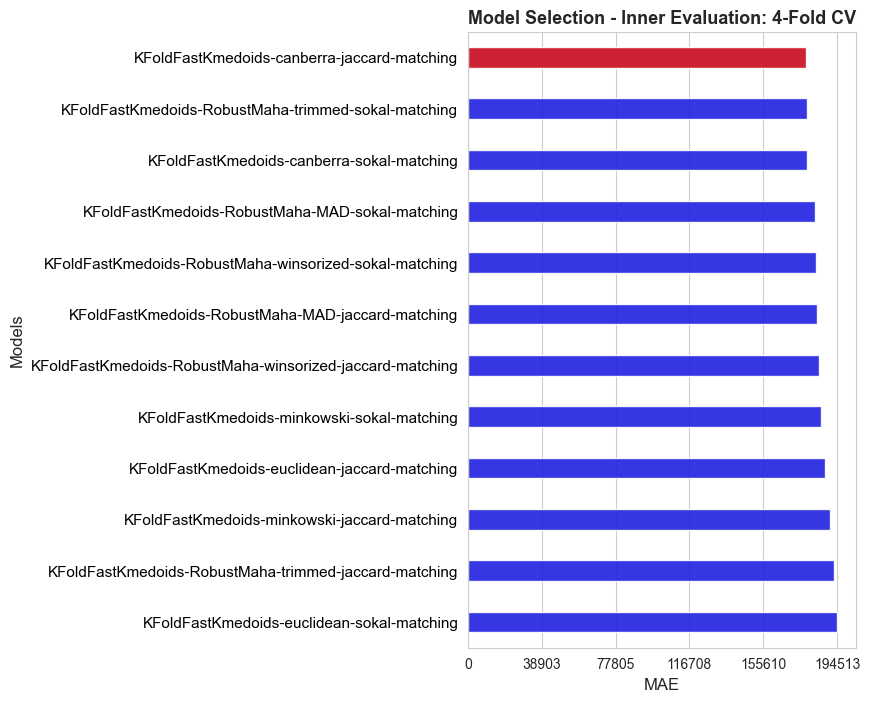

The best model among all the 12 alternatives plotted, according to the inner evaluation, is: KFoldFastKmedoids-canberra-jaccard-matching
MAE of the best model: 178316.149

The best model hyper-parameters are: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': nan, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.6, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__n_splits': 24, 'clustering_model__estimators__0__n_estimators': 58, 'clustering_model__estimators__0__max_depth': nan, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model

In [61]:
fig, axes = plt.subplots(figsize=(5,8))

ax = sns.barplot(y=sorted_pipelines, x=sorted_scores, color='blue', width=0.4, alpha=0.9)
ax = sns.barplot(y=[best_pipeline], x=[score_best_pipeline], color='red', width=0.4, alpha=0.9)

ax.set_ylabel('Models', size=12)
ax.set_xlabel('MAE', size=12)
ax.set_xticks(np.round(np.linspace(0, np.max(inner_score_values), 6),3)) 
ax.tick_params(axis='y', labelsize=11)    
plt.title(f'Model Selection - Inner Evaluation: 4-Fold CV', size=13, weight='bold')
for label in ax.get_yticklabels():
    label.set_color('black') 
plt.show()

print(f'The best model among all the {len(sorted_scores)} alternatives plotted, according to the inner evaluation, is: {best_pipeline}')
print('MAE of the best model:', np.round(score_best_pipeline, 3))
print('\nThe best model hyper-parameters are:', best_params_large[best_pipeline])